<a href="https://colab.research.google.com/github/kerenslendyrc/Estadistica/blob/main/Edpractica1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files # para cargar archivos en google colab
upload = files.upload()

Saving Base de datos.xlsx to Base de datos.xlsx


In [2]:
import pandas as pd
print(pd.__version__)
print(pd.__file__)


2.2.2
/usr/local/lib/python3.12/dist-packages/pandas/__init__.py


In [3]:
!pip install factor-analyzer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor-analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=2c97c3271ea319e82115e8cf8ce12aa4868fed1f93ae37641fd9e44b044d7fae
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor-analyzer


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity



In [5]:
import pandas as pd
import numpy as np
df = pd.read_excel("Base de datos.xlsx")

df_work = df.copy()

In [6]:
df["fallecimiento_SN"] = df["fecha_muerte"].notna().map({True: "SI", False: "NO"})

In [7]:
def capitulo_cie10(code):
    if pd.isna(code):
        return pd.NA
    c = str(code).strip()
    if len(c) == 0:
        return pd.NA
    return c[0]   # A, B, C, D, ...

df["capitulo_causa_muerte"] = df["cod_causa_basica_muerte"].apply(capitulo_cie10)


In [8]:
map_capitulos = {
    "A": "Infecciosas_parasitarias",
    "B": "Infecciosas_parasitarias",
    "C": "Neoplasias",
    "D": "Neoplasias_sangre",
    "E": "Endocrinas_nutricionales",
    "F": "Trastornos_mentales",
    "G": "Sistema_nervioso",
    "H": "Ojo_oido",
    "I": "Cardiovasculares",
    "J": "Respiratorias",
    "K": "Digestivas",
    "L": "Piel_tejido_subcutaneo",
    "M": "Musculoesqueleticas",
    "N": "Genitourinarias",
    "O": "Embarazo_parto_puerperio",
    "P": "Perinatales",
    "Q": "Malformaciones_congenitas",
    "R": "Sintomas_signos_mal_definidos",
    "S": "Traumatismos",
    "T": "Envenenamientos_y_otros_consec",
    "V": "Causas_externas_transporte",
    "W": "Causas_externas_otros",
    "X": "Causas_externas_otros2",
    "Y": "Causas_externas_otros3",
    "Z": "Factores_contacto_servicios",
}

# Rehacer la columna agrupada:
df["capitulo_causa_muerte"] = df["cod_causa_basica_muerte"].apply(capitulo_cie10)
df["grupo_causa_muerte"] = df["capitulo_causa_muerte"].map(map_capitulos)

# Si alguna letra no estaba en el diccionario, la mandas a "OTRO"
df["grupo_causa_muerte"] = df["grupo_causa_muerte"].fillna("OTRO")

# Ver ahora las categorías
df["grupo_causa_muerte"].value_counts()


,count
grupo_causa_muerte,
OTRO,138271
Neoplasias,682
Sintomas_signos_mal_definidos,615
Respiratorias,503
Cardiovasculares,346
Infecciosas_parasitarias,143
Digestivas,119
Neoplasias_sangre,90
Genitourinarias,74


In [9]:
# 1) Crear fallecimiento_SN si no lo tienes aún
df["fallecimiento_SN"] = df["fecha_muerte"].notna().map({True: "SI", False: "NO"})

# 2) Crear capítulo y grupo solo para quienes tienen código
df["capitulo_causa_muerte"] = df["cod_causa_basica_muerte"].apply(capitulo_cie10)

df["grupo_causa_muerte"] = df["capitulo_causa_muerte"].map(map_capitulos)

# 3) Diferenciar bien:
# - NO_APLICA si no falleció
# - OTRO solo si falleció pero la letra no está en el map_capitulos
df.loc[df["fallecimiento_SN"] == "NO", "grupo_causa_muerte"] = "NO_APLICA"
df.loc[
    (df["fallecimiento_SN"] == "SI") & (df["grupo_causa_muerte"].isna()),
    "grupo_causa_muerte"
] = "OTRO"

df["grupo_causa_muerte"].value_counts()


,count
grupo_causa_muerte,
NO_APLICA,138098
Neoplasias,681
Sintomas_signos_mal_definidos,615
Respiratorias,502
Cardiovasculares,346
OTRO,175
Infecciosas_parasitarias,143
Digestivas,119
Neoplasias_sangre,90


In [10]:
def agrupar_uo_medico_macro(uo):
    if pd.isna(uo):
        return "OTRA"
    u = str(uo).upper()

    # Cuidados intensivos
    if "INTEN" in u:  # 1MHINTEN
        return "UCI"

    # Pediatría
    if "PEDIA" in u or "CXPED" in u or "ORTPE" in u or "NEONA" in u or "ORPED" in u or "OFPED" in u:
        return "PEDIATRIA"

    # Ginecología / Obstetricia
    if "GINEC" in u or "GINEO" in u or "CACUE" in u:  # CACUE lo mando a gineco-onco
        return "GINECOLOGIA"

    # Medicina Interna
    if "MEINT" in u:
        return "MEDICINA_INTERNA"

    # Cirugía (general y subespecialidades CX***, COLOP, etc.)
    if "CX" in u or "COLOP" in u:
        return "CIRUGIA"

    # Urología
    if "UROLO" in u or "UROLP" in u or "URONC" in u:
        return "UROLOGIA"

    # Hematología / Hemato-oncología
    if "HEMAT" in u or "HEMTR" in u or "HEONP" in u or "HE-ON" in u or "HEMAP" in u:
        return "HEMATOLOGIA_ONCO"

    # Oncología (códigos ONCO específicos)
    if "ONCOL" in u or "ONCOP" in u or "CXONC" in u or "ORON" in u:
        return "ONCOLOGIA"

    # Oftalmología
    if "OFTAL" in u or "OFPLA" in u or "RETIN" in u or "OFPED" in u or "NEUOF" in u:
        return "OFTALMOLOGIA"

    # Neurología
    if "NEURO" in u or "NEURP" in u:
        return "NEUROLOGIA"

    # Nefrología
    if "NEFRO" in u or "NEFTR" in u or "NEFRP" in u:
        return "NEFROLOGIA"

    # Ortopedia
    if "ORTOP" in u or "ORTOD" in u:
        return "ORTOPEDIA"

    # Alergia
    if "ALERG" in u:
        return "ALERGOLOGIA"

    # Geriatría
    if "GERIA" in u:
        return "GERIATRIA"

    # Cardiología
    if "CARDI" in u:
        return "CARDIOLOGIA"

    # Gastroenterología
    if "GASTR" in u or "GASTP" in u:
        return "GASTROENTEROLOGIA"

    # Otorrino
    if "OTORR" in u or "OTOLO" in u:
        return "OTORRINOLARINGOLOGIA"

    # Imagen/diagnóstico (radiología, med nuclear, laboratorio especial)
    if "RADIN" in u or "RADIO" in u or "MENUC" in u or "MELAB" in u:
        return "IMAGENOLOGIA"

    # Reumatología
    if "REUMA" in u or "REUMP" in u:
        return "REUMATOLOGIA"

    # Endocrinología
    if "ENDOC" in u:
        return "ENDOCRINOLOGIA"

    # Urgencias
    if "URGEN" in u:
        return "URGENCIAS"

    # Anestesiología
    if "ANECL" in u:
        return "ANESTESIOLOGIA"

    return "OTRA"

# Recalcular la macro-categoría
df["uo_medico_macro"] = df["uo_medico"].apply(agrupar_uo_medico_macro)

# Ver cómo queda ahora la distribución
df["uo_medico_macro"].value_counts()


,count
uo_medico_macro,
MEDICINA_INTERNA,54633
GINECOLOGIA,30799
PEDIATRIA,17409
CIRUGIA,15668
HEMATOLOGIA_ONCO,6746
UROLOGIA,4853
ORTOPEDIA,3865
ANESTESIOLOGIA,2861
URGENCIAS,1205


In [11]:
df.loc[df["uo_medico_macro"] == "OTRA", "uo_medico"].value_counts().head(20)


,count
uo_medico,
1MHPERIN,6
1MHINFEC,5
1MHANDRO,4
1MHCARDP,3
1MHCARIN,3
1MHINTEP,2
1MHOFCOR,2
1MHOFSEG,2
1MHNEUMO,1


In [12]:
# Ver las unidades más frecuentes
vc_uo = df["id_discapacidad"].value_counts()
top_uo = vc_uo.head(50).index   # por ejemplo, las 20 más frecuentes

# Crear grupo: top unidades vs resto
df["id_discapacidad_top"] = df["id_discapacidad"].where(df["id_discapacidad"].isin(top_uo), "OTRAS_UNIDADES")

df["id_discapacidad_top"].value_counts()


,count
id_discapacidad_top,
Ninguna,103486
OTRAS_UNIDADES,27745
Movimiento cuerpo extremidades,3277
El sistema nervioso,1457
Cardiorespiratorio y/o defensas,1278
"El sistema nervioso, Movimiento cuerpo extremidades",831
Los ojos,668
Los oÃ­dos,308
RENAL,298


In [13]:
def agrupar_discapacidad_macro(desc):
    # 1) Faltantes o punto suelto
    if pd.isna(desc):
        return "DESCONOCIDA"
    s = str(desc).upper().strip()

    # 2) Sin discapacidad
    if "NINGUNA" in s or s == "NINGUNA" or "NO APLICA" in s:
        return "SIN_DISCAPACIDAD"

    # 3) Preparamos flags por sistema / tipo
    grupos = []

    # Motora / aparato locomotor
    if "MOVIMIENTO CUERPO" in s or "EXTREMIDADES" in s:
        grupos.append("MOTORA")
    if "ÓSEA" in s or "Ã“SEA" in s or "OSEA" in s:
        grupos.append("MOTORA")

    # Neurológica / cognitiva
    if "SISTEMA NERVIOSO" in s or "DEMENCIA" in s:
        grupos.append("NEUROLOGICA")

    # Cardiorrespiratorio y defensas
    if "CARDIORRESPIRATORIO" in s or "CARDIORESPIRATORIO" in s or "DEFENSAS" in s:
        grupos.append("CARDIORESPIRATORIA_DEFENSAS")

    # Sensorial visual
    if "LOS OJOS" in s or "OJOS" in s:
        grupos.append("SENSORIAL_VISUAL")

    # Sensorial auditiva (ojo con caracteres raros)
    if "LOS OÍDOS" in s or "LOS OIDOS" in s or "LOS OÃDOS" in s or "OÍDOS" in s or "OIDOS" in s or "OÃDOS" in s:
        grupos.append("SENSORIAL_AUDITIVA")

    # Comunicación (voz y habla)
    if "VOZ" in s or "HABLA" in s:
        grupos.append("COMUNICACION")

    # Renal
    if "RENAL" in s:
        grupos.append("RENAL")

    # Metabólica / endocrina / digestiva
    if "DIGESTI" in s or "METABOL" in s or "HORMONAL" in s or "OBESIDAD" in s or "ENDOCR" in s:
        grupos.append("METABOLICA_ENDOCRINA")

    # Piel
    if "LA PIEL" in s or "PIEL" in s:
        grupos.append("PIEL")

    # Genital / reproductivo
    if "GENITAL" in s or "REPRODUCTIVO" in s:
        grupos.append("GENITAL_REPRODUCTIVO")

    # Inmunidad / hematológica / onco-hemato
    if "INMUNIDAD" in s or "HEMATOLOGICA" in s or "CITOPENIAS" in s or "HODGKIN" in s:
        grupos.append("INMUNO_HEMATOLOGICA")

    # 4) Si tiene varias áreas a la vez → MULTIPLE
    grupos_unicos = list(set(grupos))

    if len(grupos_unicos) == 0:
        # Casos especiales que son más bien diagnósticos pero los tiramos a INMUNO/HEMATO o OTRA
        if "CA DE MAMA" in s or "MAMA" in s:
            return "INMUNO_HEMATOLOGICA"
        if "QUIMIOTERAPIA" in s:
            return "INMUNO_HEMATOLOGICA"
        if "EDAD" in s:
            return "MOTORA"   # fragilidad asociada a edad, si quieres puedes crear una categoría aparte
        if "OTRAS_UNIDADES" in s or s == ".":
            return "OTRA"
        # Nada matchea → OTRA
        return "OTRA"

    if len(grupos_unicos) == 1:
        return grupos_unicos[0]

    # Si tiene más de un sistema comprometido
    return "MULTIPLE"


# Aplicar sobre la columna de texto de discapacidad
df["tipo_discapacidad_macro"] = df["id_discapacidad_top"].apply(agrupar_discapacidad_macro)

# Ver cómo quedó
df["tipo_discapacidad_macro"].value_counts()


,count
tipo_discapacidad_macro,
SIN_DISCAPACIDAD,103591
OTRA,28118
MOTORA,3443
MULTIPLE,1585
NEUROLOGICA,1476
CARDIORESPIRATORIA_DEFENSAS,1278
SENSORIAL_VISUAL,704
RENAL,332
METABOLICA_ENDOCRINA,232


In [14]:
df.loc[df["tipo_discapacidad_macro"] == "OTRA", "id_discapacidad_top"] \
  .value_counts() \
  .head(30)


,count
id_discapacidad_top,
OTRAS_UNIDADES,27745
Los oÃ­dos,308
.,41
Olfato tacto y/o gusto,24


In [15]:
# 1) Los oídos → sensorial auditiva
mask_oidos = df["id_discapacidad_top"].str.contains("Los oÃ­dos", case=False, na=False)
df.loc[mask_oidos, "tipo_discapacidad_macro"] = "SENSORIAL_AUDITIVA"

# 2) Olfato tacto y/o gusto → sensorial otros
mask_olfato = df["id_discapacidad_top"].str.contains("Olfato tacto y/o gusto", case=False, na=False)
df.loc[mask_olfato, "tipo_discapacidad_macro"] = "SENSORIAL_OTROS"

# 3) Si quieres separar el punto como DESCONOCIDA
mask_punto = df["id_discapacidad_top"].eq(".")
df.loc[mask_punto, "tipo_discapacidad_macro"] = "DESCONOCIDA"

# Ver cómo queda
df["tipo_discapacidad_macro"].value_counts()


,count
tipo_discapacidad_macro,
SIN_DISCAPACIDAD,103533
OTRA,27745
MOTORA,3348
MULTIPLE,1585
NEUROLOGICA,1476
CARDIORESPIRATORIA_DEFENSAS,1278
SENSORIAL_VISUAL,668
SENSORIAL_AUDITIVA,522
RENAL,332


In [16]:
import numpy as np
import pandas as pd

# 1) Estandarizar nombres de ciudad y departamento
df['ciudad_clean'] = (
    df['ciudad']
    .astype(str)
    .str.strip()
    .str.upper()
)

df['departamento_clean'] = (
    df['departamento']
    .astype(str)
    .str.strip()
    .str.upper()
)

# 2) Diccionario municipio -> provincia (solo SANTANDER)
provincia_map = {
    # --- METROPOLITANA ---
    'BUCARAMANGA': 'Metropolitana',
    'FLORIDABLANCA': 'Metropolitana',
    'GIRÓN': 'Metropolitana',
    'GIRON': 'Metropolitana',        # por si viene sin tilde
    'PIEDECUESTA': 'Metropolitana',
    'LEBRIJA': 'Metropolitana',
    'LOS SANTOS': 'Metropolitana',
    'RIONEGRO': 'Metropolitana',
    'SANTA BÁRBARA': 'Metropolitana',
    'SANTA BARBARA': 'Metropolitana',
    'ZAPATOCA': 'Metropolitana',
    'EL PLAYÓN': 'Metropolitana',
    'EL PLAYON': 'Metropolitana',
    # Decide tú si TONA va aquí o en Soto Norte:
    'TONA': 'Metropolitana',

    # --- COMUNERA ---
    'CHIMA': 'Comunera',
    'CONFINES': 'Comunera',
    'CONTRATACIÓN': 'Comunera',
    'CONTRATACION': 'Comunera',
    'EL GUACAMAYO': 'Comunera',
    'GALÁN': 'Comunera',
    'GALAN': 'Comunera',
    'GÁMBITA': 'Comunera',
    'GAMBITA': 'Comunera',
    'GUADALUPE': 'Comunera',
    'GUAPOTÁ': 'Comunera',
    'GUAPOTA': 'Comunera',
    'HATO': 'Comunera',
    'OIBA': 'Comunera',
    'PALMAR': 'Comunera',
    'PALMAS DEL SOCORRO': 'Comunera',
    'SANTA HELENA DEL OPÓN': 'Comunera',
    'SANTA HELENA DEL OPON': 'Comunera',
    'SIMACOTA': 'Comunera',
    'SOCORRO': 'Comunera',
    'SUAITA': 'Comunera',

    # --- VÉLEZ ---
    'AGUADA': 'Vélez',
    'ALBANIA': 'Vélez',
    'BARBOSA': 'Vélez',
    'BOLÍVAR': 'Vélez',
    'BOLIVAR': 'Vélez',
    'CHIPATÁ': 'Vélez',
    'CHIPATA': 'Vélez',
    'CIMITARRA': 'Vélez',
    'EL PEÑÓN': 'Vélez',
    'EL PENON': 'Vélez',
    'FLORIÁN': 'Vélez',
    'FLORIAN': 'Vélez',
    'GUAVATÁ': 'Vélez',
    'GUAVATA': 'Vélez',
    'GÜEPSA': 'Vélez',
    'GUEPSA': 'Vélez',
    'JESÚS MARÍA': 'Vélez',
    'JESUS MARIA': 'Vélez',
    'LA BELLEZA': 'Vélez',
    'LA PAZ': 'Vélez',
    'LANDÁZURI': 'Vélez',
    'LANDAZURI': 'Vélez',
    'PUENTE NACIONAL': 'Vélez',
    'PUERTO PARRA': 'Vélez',
    'SAN BENITO': 'Vélez',
    'SUAREZ': 'Vélez',   # si apareciera así en tus datos
    'SUCRE': 'Vélez',
    'VÉLEZ': 'Vélez',
    'VELEZ': 'Vélez',

    # --- GUANENTÁ ---
    'ARATOCA': 'Guanentá',
    'BARICHARA': 'Guanentá',
    'CABRERA': 'Guanentá',
    'CHARALÁ': 'Guanentá',
    'CHARALA': 'Guanentá',
    'COROMORO': 'Guanentá',
    'CURITÍ': 'Guanentá',
    'CURITI': 'Guanentá',
    'ENCINO': 'Guanentá',
    'JORDÁN': 'Guanentá',
    'JORDAN': 'Guanentá',
    'MOGOTES': 'Guanentá',
    'OCAMONTE': 'Guanentá',
    'ONZAGA': 'Guanentá',
    'PÁRAMO': 'Guanentá',
    'PARAMO': 'Guanentá',
    'PINCHOTE': 'Guanentá',
    'SAN GIL': 'Guanentá',
    'SAN JOAQUÍN': 'Guanentá',
    'SAN JOAQUIN': 'Guanentá',
    'VALLE DE SAN JOSÉ': 'Guanentá',
    'VALLE DE SAN JOSE': 'Guanentá',
    'VILLANUEVA': 'Guanentá',

    # --- GARCÍA ROVIRA ---
    'CAPITANEJO': 'García Rovira',
    'CARCASÍ': 'García Rovira',
    'CARCASI': 'García Rovira',
    'CEPITÁ': 'García Rovira',
    'CEPITA': 'García Rovira',
    'CERRITO': 'García Rovira',
    'CONCEPCIÓN': 'García Rovira',
    'CONCEPCION': 'García Rovira',
    'ENCISO': 'García Rovira',
    'GUACA': 'García Rovira',
    'MACARAVITA': 'García Rovira',
    'MÁLAGA': 'García Rovira',
    'MALAGA': 'García Rovira',
    'MOLAGAVITA': 'García Rovira',
    'SAN ANDRÉS': 'García Rovira',
    'SAN ANDRES': 'García Rovira',
    'SAN JOSÉ DE MIRANDA': 'García Rovira',
    'SAN JOSE DE MIRANDA': 'García Rovira',
    'SAN MIGUEL': 'García Rovira',

    # --- YARIGUÍES ---
    'BARRANCABERMEJA': 'Yariguíes',
    'BETULIA': 'Yariguíes',
    'EL CARMEN DE CHUCURÍ': 'Yariguíes',
    'EL CARMEN DE CHUCURI': 'Yariguíes',
    'PUERTO WILCHES': 'Yariguíes',
    'SABANA DE TORRES': 'Yariguíes',
    'SAN VICENTE DE CHUCURÍ': 'Yariguíes',
    'SAN VICENTE DE CHUCURI': 'Yariguíes',

    # --- SOTO / SOTO NORTE ---
    'CALIFORNIA': 'Soto Norte',
    'CHARTA': 'Soto Norte',
    'MATANZA': 'Soto Norte',
    'SURATÁ': 'Soto Norte',
    'SURATA': 'Soto Norte',
    'VETAS': 'Soto Norte',
    # Si prefieres que Tona quede aquí:
    # 'TONA': 'Soto Norte',
}

# 3) Crear la variable provincia_ciudad para SANTANDER
df['provincia_ciudad'] = df['ciudad_clean'].map(provincia_map)

# 4) Asignar 'Otros departamentos' para todo lo que no es Santander
df.loc[df['departamento_clean'] != 'SANTANDER', 'provincia_ciudad'] = 'Otros departamentos'

# 5) Cualquier municipio de Santander no mapeado explícitamente también va a 'Otros departamentos'
df['provincia_ciudad'] = df['provincia_ciudad'].fillna('Otros departamentos')

# Opcional: revisar distribución
print(df['provincia_ciudad'].value_counts(dropna=False))


provincia_ciudad
Metropolitana          116917
Otros departamentos      9042
Yariguíes                6759
Guanentá                 3751
Vélez                    1832
Comunera                 1432
García Rovira             852
Soto Norte                570
Name: count, dtype: int64


In [17]:
eps_counts = df['EPS'].value_counts(dropna=False)
print(eps_counts.head(30))


EPS
NUEVA EPS                        103886
FIDUPREVISORA                     12194
ECOPETROL                          4694
EPS SANITAS                        3975
COLSANITAS                         1884
EPS FAMISANAR                      1728
SURAMERICANA SA                    1693
CLINICA SANTA CRUZ DE LA LOMA      1446
COOSALUD EPS                       1269
AXA COLPATRIA                      1216
SALUD TOTAL EPS                     795
ALLIANZ SEGUROS                     720
MEDISANITAS                         623
COLMEDICA MEDICINA PREPAGADA        537
COOMEVA EPS                         439
UIS                                 397
SEGUROS BOLIVAR                     360
PACIENTE PARTICULAR                 288
SALUD TOTAL SUBSIADO                250
HDI SEGUROS (ANTES LIBERTY)         224
MED PLUS MEDICINA PREPAGADA         212
COMPENSAR EPS                       198
CORSO SALAMANCA JAIRO               183
FUNDACION MEDICO PREVENTIVA         169
COMPAÃ‘IA MUNDIAL DE SEGUROS        

In [18]:
# 1) Limpieza básica
df['EPS_clean'] = (
    df['EPS']
    .astype(str)
    .str.strip()
    .str.upper()
)

# 2) Unificar TODAS las variantes que contengan "NUEVA EPS"
mask_nueva = df['EPS_clean'].str.contains('NUEVA EPS', na=False)
df.loc[mask_nueva, 'EPS_clean'] = 'NUEVA EPS'

# 3) Recalcular frecuencias sobre la columna ya unificada
eps_freq = df['EPS_clean'].value_counts(normalize=True)

umbral_grande = 0.05
umbral_mediana_inf = 0.01

def clasificar_eps(eps):
    if pd.isna(eps):
        return 'EPS_no_reportada'
    if eps == 'NUEVA EPS':
        return 'EPS_NUEVA'
    f = eps_freq.get(eps, 0)
    if f >= umbral_grande:
        return 'EPS_grandes'
    elif f >= umbral_mediana_inf:
        return 'EPS_medianas'
    else:
        return 'EPS_pequeñas'

df['EPS_grupo'] = df['EPS_clean'].apply(clasificar_eps)

print(df.loc[df['EPS_clean'] == 'NUEVA EPS', 'EPS_grupo'].value_counts())


EPS_grupo
EPS_NUEVA    103887
Name: count, dtype: int64


In [19]:
# Ver todas las variantes que contienen "NUEVA EPS"
mask_nueva = df['EPS_clean'].str.contains('NUEVA EPS', na=False)

print(df.loc[mask_nueva, 'EPS_clean'].value_counts())
print(df.loc[mask_nueva, 'EPS_grupo'].value_counts())


EPS_clean
NUEVA EPS    103887
Name: count, dtype: int64
EPS_grupo
EPS_NUEVA    103887
Name: count, dtype: int64


In [20]:
import pandas as pd

# Tabla con EPS limpia, grupo y frecuencia absoluta
tabla_eps = (
    df
    .groupby(['EPS_grupo', 'EPS_clean'])
    .size()
    .reset_index(name='n_pacientes')
    .sort_values(['EPS_grupo', 'n_pacientes'], ascending=[True, False])
)

print("=== EPS por grupo (con número de pacientes) ===")
print(tabla_eps)

# Si quieres ver solo los nombres de EPS por grupo:
eps_por_grupo = (
    tabla_eps
    .groupby('EPS_grupo')['EPS_clean']
    .apply(list)
)

print("\n=== Listado de EPS en cada grupo ===")
for grupo, lista_eps in eps_por_grupo.items():
    print(f"\nGrupo: {grupo}")
    for eps in lista_eps:
        print(f"  - {eps}")


=== EPS por grupo (con número de pacientes) ===
       EPS_grupo                   EPS_clean  n_pacientes
0      EPS_NUEVA                   NUEVA EPS       103887
1    EPS_grandes               FIDUPREVISORA        12194
4   EPS_medianas                   ECOPETROL         4694
6   EPS_medianas                 EPS SANITAS         3975
3   EPS_medianas                  COLSANITAS         1884
..           ...                         ...          ...
53  EPS_pequeñas  LA Â CLINIC Â DU CORPS LTD            1
78  EPS_pequeñas   TRAVEL GUARD AMERICAS LLC            1
80  EPS_pequeñas                      UNACSA            1
83  EPS_pequeñas    UNION TEMPORAL TOLIHUILA            1
86  EPS_pequeñas        YEPES PEREZ HERNANDO            1

[87 rows x 3 columns]

=== Listado de EPS en cada grupo ===

Grupo: EPS_NUEVA
  - NUEVA EPS

Grupo: EPS_grandes
  - FIDUPREVISORA

Grupo: EPS_medianas
  - ECOPETROL
  - EPS SANITAS
  - COLSANITAS
  - EPS FAMISANAR
  - SURAMERICANA SA
  - CLINICA SANTA CRU

dummies


In [21]:
# 2) Columnas categóricas que sí vamos a convertir en dummies
cols_a_dummificar = [
    "provincia_ciudad",
    "Servicio",
    "asignacion_enfermeria",
    "gran_causa_morbilidad",
    "uo_medico_macro",
    "sexo",
    "EPS_grupo",
    "tipo_discapacidad_macro",
    "fallecimiento_SN"   # SÍ / NO
]

# Por seguridad: nos quedamos solo con las que realmente existan en df
cols_existentes = [c for c in cols_a_dummificar if c in df.columns]
cols_faltantes = [c for c in cols_a_dummificar if c not in df.columns]

print("Dummificando columnas:", cols_existentes)
print("No se encontraron en df:", cols_faltantes)


Dummificando columnas: ['provincia_ciudad', 'Servicio', 'asignacion_enfermeria', 'gran_causa_morbilidad', 'uo_medico_macro', 'sexo', 'EPS_grupo', 'tipo_discapacidad_macro', 'fallecimiento_SN']
No se encontraron en df: []


In [22]:
cols_cardinalidad = [
    "provincia_ciudad",
    "Servicio",
    "asignacion_enfermeria",
    "gran_causa_morbilidad",
    "uo_medico_macro",
    "sexo",
    "EPS_grupo",
    "tipo_discapacidad_macro",
    "fallecimiento_SN"
]

print("=== Cardinalidad de variables categóricas ===\n")

resumen = []
for col in cols_cardinalidad:
    n_cat = df[col].nunique(dropna=True)
    resumen.append({"variable": col, "n_categorias": n_cat})

    print(f"Variable: {col}")
    print(f" - Número de categorías: {n_cat}")
    print(" - Top 10 categorías más frecuentes:")
    print(df[col].value_counts(dropna=False).head(10))
    print("\n" + "-"*60 + "\n")


=== Cardinalidad de variables categóricas ===

Variable: provincia_ciudad
 - Número de categorías: 8
 - Top 10 categorías más frecuentes:
provincia_ciudad
Metropolitana          116917
Otros departamentos      9042
Yariguíes                6759
Guanentá                 3751
Vélez                    1832
Comunera                 1432
García Rovira             852
Soto Norte                570
Name: count, dtype: int64

------------------------------------------------------------

Variable: Servicio
 - Número de categorías: 5
 - Top 10 categorías más frecuentes:
Servicio
Hospitalización adultos       95766
Ginecobstetricia              22748
Hospitalización pediatrica    18748
UCI Adultos                    2980
UCI Pediatrica                  913
Name: count, dtype: int64

------------------------------------------------------------

Variable: asignacion_enfermeria
 - Número de categorías: 28
 - Top 10 categorías más frecuentes:
asignacion_enfermeria
1 UE HOSP URGENCIAS CAL P5        42

In [23]:
# 3) Dummies 0/1 para las columnas categóricas
df_dummies = pd.get_dummies(
    df[cols_existentes],
    columns=cols_existentes,
    drop_first=False,   # conserva todas las categorías (útil para análisis descriptivo)
    dtype=int
)

# 4) Construir un DataFrame final mezclando edad + dummies
X_dummis = pd.concat(
    [
        df[["edad"]].reset_index(drop=True),  # edad numérica
        df_dummies.reset_index(drop=True)
    ],
    axis=1
)

X_dummis.head()


,edad,provincia_ciudad_Comunera,provincia_ciudad_García Rovira,provincia_ciudad_Guanentá,provincia_ciudad_Metropolitana,provincia_ciudad_Otros departamentos,provincia_ciudad_Soto Norte,provincia_ciudad_Vélez,provincia_ciudad_Yariguíes,Servicio_Ginecobstetricia,...,tipo_discapacidad_macro_NEUROLOGICA,tipo_discapacidad_macro_OTRA,tipo_discapacidad_macro_PIEL,tipo_discapacidad_macro_RENAL,tipo_discapacidad_macro_SENSORIAL_AUDITIVA,tipo_discapacidad_macro_SENSORIAL_OTROS,tipo_discapacidad_macro_SENSORIAL_VISUAL,tipo_discapacidad_macro_SIN_DISCAPACIDAD,fallecimiento_SN_NO,fallecimiento_SN_SI
0,31,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,77,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,76,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,67,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,67,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [24]:
# 1) Matriz de entrada para PCA
X = X_dummis.copy()
features = X.columns

# 2) Estandarización (media 0, varianza 1)
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)


In [25]:
from sklearn.decomposition import PCA
import numpy as np

# X_scaled es tu matriz estandarizada (la que ya tenías)
n_muestras = min(30000, X_scaled.shape[0])  # por ejemplo, máximo 30k filas
idx = np.random.choice(X_scaled.shape[0], size=n_muestras, replace=False)
X_sample = X_scaled[idx]

# PCA que elige automáticamente los componentes para explicar el 85% de la varianza
pca_sample = PCA(
    n_components=0.85,      # queremos ≥ 85% de varianza
    svd_solver="full",      # obligatorio para usar float como n_components
    random_state=0
)

X_pca_sample = pca_sample.fit_transform(X_sample)

# Número de componentes que alcanzan ≥85% en la muestra
n_components_85 = pca_sample.n_components_
print("Componentes necesarios (muestra) para ≥85% varianza:", n_components_85)

# Si quieres ver la varianza acumulada en la muestra:
explained_var_sample = pca_sample.explained_variance_ratio_
cum_var_sample = np.cumsum(explained_var_sample)
print("Varianza acumulada en la muestra:", cum_var_sample)



Componentes necesarios (muestra) para ≥85% varianza: 61
Varianza acumulada en la muestra: [0.05678317 0.09268148 0.12064425 0.14732608 0.16941951 0.19017429
 0.21035442 0.2300533  0.24900033 0.26648074 0.28370471 0.30048784
 0.31650046 0.33207621 0.34718114 0.36131898 0.37502069 0.38853367
 0.40192322 0.4151481  0.42812936 0.44079099 0.45321334 0.46540718
 0.47739624 0.48916021 0.50084683 0.51242584 0.52395286 0.5353686
 0.54668877 0.55798211 0.56924298 0.58035446 0.59141193 0.60242535
 0.61336992 0.62427551 0.63512915 0.64597421 0.65675688 0.66741635
 0.67802104 0.68855531 0.69895801 0.70932021 0.71966592 0.7299426
 0.74014226 0.75033052 0.76037751 0.77037098 0.78030375 0.79015841
 0.7999646  0.80974121 0.8195008  0.82922906 0.83893972 0.84859174
 0.85818158]


In [26]:
# Supón que tienes pca y explained_variance_ratio_
var_acum = pca_sample.explained_variance_ratio_.cumsum()
for k in [10, 20, 30, 40]:
    print(k, var_acum[k-1])


10 0.26648073890103435
20 0.4151480976491065
30 0.535368599759199
40 0.6459742143542122


Analisis factorial

Inicialmente, con variables dummificadas sin agrupar, el PCA requería 263 componentes para el 85% de la varianza y el KMO era 0.055.

Tras agrupar ciudad en provincias / otros departamentos y agrupar EPS en categorías por tamaño, el número de componentes para 85% de la varianza se redujo a 61 y el KMO subió a 0.106.

Esto muestra una ligera mejora en la estructura común, pero los valores de KMO siguen indicando que el análisis factorial clásico no es adecuado para este conjunto de variables.

Por tanto, se utiliza el PCA principalmente como reducción de dimensión previa al clustering, y se consideran enfoques alternativos (p. ej. MCA / distancias de Gower) para tratar la naturaleza categórica de las variables.

In [27]:
X = df_dummies.copy()

# --- KMO ---
kmo_all, kmo_model = calculate_kmo(X)
print(f"KMO global del modelo: {kmo_model:.3f}")

# --- Bartlett ---
chi_square_value, p_value = calculate_bartlett_sphericity(X)
print(f"Test de Bartlett: chi2 = {chi_square_value:.2f}, p-value = {p_value:.5f}")


/usr/local/lib/python3.12/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


KMO global del modelo: 0.106
Test de Bartlett: chi2 = nan, p-value = nan


/usr/local/lib/python3.12/dist-packages/factor_analyzer/factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)


Se intentó ajustar un modelo de análisis factorial exploratorio sobre el conjunto completo de variables categóricas dummificadas, pero los indicadores de adecuación muestral (KMO) mostraron que el modelo factorial no resultaba apropiado, por lo que se descartó este enfoque global.

In [28]:
from factor_analyzer.factor_analyzer import calculate_kmo

# X_dummies: tu matriz después de todas las recodificaciones
kmo_all, kmo_vars = calculate_kmo(X_dummis)

kmo_all  # KMO global
kmo_vars  # array con KMO por variable

# Ver variables con KMO más bajo
kmo_por_variable = pd.DataFrame({
    'variable': X_dummis.columns,
    'kmo': kmo_vars
}).sort_values('kmo')

kmo_por_variable.head(20)


,variable,kmo
0,edad,0.116233
1,provincia_ciudad_Comunera,0.116233
2,provincia_ciudad_García Rovira,0.116233
3,provincia_ciudad_Guanentá,0.116233
4,provincia_ciudad_Metropolitana,0.116233
5,provincia_ciudad_Otros departamentos,0.116233
6,provincia_ciudad_Soto Norte,0.116233
7,provincia_ciudad_Vélez,0.116233
8,provincia_ciudad_Yariguíes,0.116233
9,Servicio_Ginecobstetricia,0.116233


calculo de entropía:

In [29]:
from sklearn.decomposition import PCA
import numpy as np

# Supongo que ya entrenaste el PCA:
# pca = PCA(...).fit(X)
# y que tu objeto se llama:
pca = pca_sample

# 1) Proporción de varianza explicada por cada componente
prop_var = pca.explained_variance_ratio_  # array de longitud n_components

# 2) Asegurar que sumen 1 (por si acaso)
p = prop_var / prop_var.sum()

# 3) Entropía (log natural)
entropy_pca = -np.sum(p * np.log(p))

# 4) (Opcional) Entropía normalizada entre 0 y 1
entropy_pca_norm = entropy_pca / np.log(len(p))

print("Entropía PCA:", entropy_pca)
print("Entropía PCA normalizada:", entropy_pca_norm)



Entropía PCA: 4.01309063168281
Entropía PCA normalizada: 0.9762135167068267


In [30]:
from factor_analyzer import FactorAnalyzer
import numpy as np

n_factors = 10  # ?????????????????

fa = FactorAnalyzer(n_factors=n_factors, rotation=None)
fa.fit(X_dummis)

var_factors, prop_var, cum_var = fa.get_factor_variance()

p = prop_var / prop_var.sum()

entropy_fa = -np.sum(p * np.log(p))
entropy_fa_norm = entropy_fa / np.log(len(p))

print("Entropía AF:", entropy_fa)
print("Entropía AF normalizada:", entropy_fa_norm)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/factor_analyzer/utils.py:166: RuntimeWarning: divide by zero encountered in divide
  smc = 1 - 1 / np.diag(corr_inv)


Entropía AF: 2.1904036546760515
Entropía AF normalizada: 0.951280220366525


Se calculó la entropía de Shannon asociada a la distribución de la varianza explicada por los componentes del PCA y los factores del AF.

Valores cercanos a 1 en la entropía normalizada indican que la varianza explicada se distribuye de manera relativamente homogénea entre un número elevado de componentes/factores, en lugar de concentrarse en unas pocas dimensiones dominantes.
Esto sugiere que la estructura latente de los datos es altamente dispersa y que ni el PCA ni el AF logran condensar la mayor parte de la información en un conjunto reducido de dimensiones.
Estas observaciones son coherentes con el bajo índice KMO obtenido, que ya advertía sobre una varianza común limitada entre las variables.”


PCA y AF no revelan pocos “factores fuertes”, sino muchos ejes débiles.

se usará el PCA principalmente como reducción técnica de dimensión antes del clustering, más que para interpretar factores/ componentes como constructos clínicos bien definidos.

K means

In [31]:
import numpy as np

# Proyección de TODO X_scaled a PCA usando el modelo entrenado en la muestra
X_pca_full = pca_sample.transform(X_scaled)

print("Shape de X_pca_full:", X_pca_full.shape)
print("Número de componentes (≥ 85% varianza):", n_components_85)


Shape de X_pca_full: (141155, 61)
Número de componentes (≥ 85% varianza): 61


Shape de X_clust (para búsqueda de k): (30000, 61)
Entrenando KMeans con k = 2...
   Inercia: 2336734.44 | Silueta: 0.0842
Entrenando KMeans con k = 3...
   Inercia: 2242233.70 | Silueta: 0.0700
Entrenando KMeans con k = 4...
   Inercia: 2207900.52 | Silueta: 0.0823
Entrenando KMeans con k = 5...
   Inercia: 2133940.71 | Silueta: 0.0918
Entrenando KMeans con k = 6...
   Inercia: 2078024.23 | Silueta: 0.1002
Entrenando KMeans con k = 7...
   Inercia: 2036359.10 | Silueta: 0.0997
Entrenando KMeans con k = 8...
   Inercia: 2019530.88 | Silueta: 0.0865
Entrenando KMeans con k = 9...
   Inercia: 1981581.12 | Silueta: 0.1073
Entrenando KMeans con k = 10...
   Inercia: 1897073.22 | Silueta: 0.1323


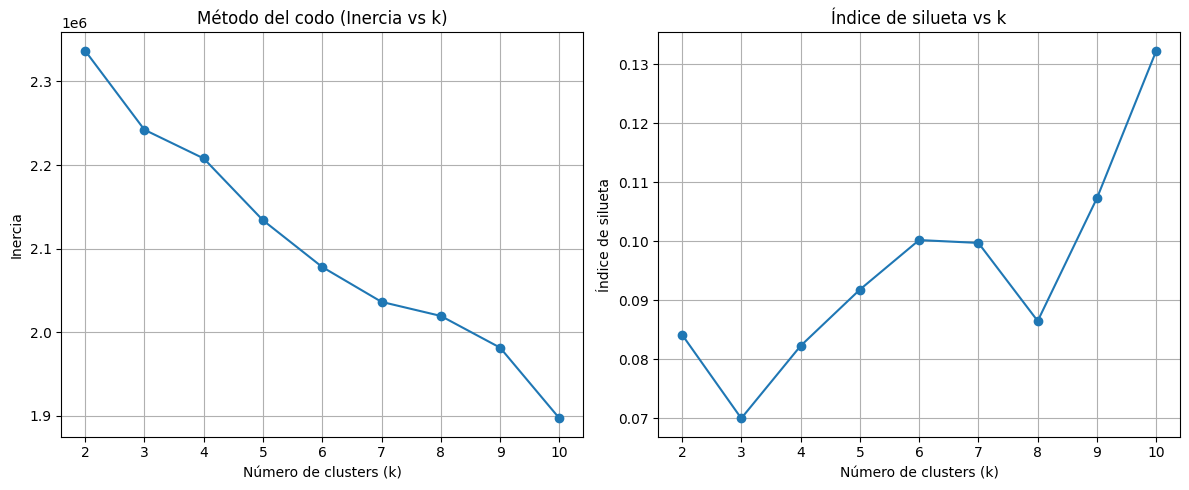

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1) Escogemos con qué matriz trabajar para elegir k
#    Usamos la muestra proyectada en PCA (más ligera).
# ------------------------------------------------------------------
X_clust = X_pca_sample

# Si quieres, podrías usar X_pca_full, pero será más pesado.
print("Shape de X_clust (para búsqueda de k):", X_clust.shape)

# ------------------------------------------------------------------
# 2) Rango de k a evaluar
# ------------------------------------------------------------------
k_values = range(2, 11)  # k = 2,3,...,10  (ajusta si quieres)
inertias = []
silhouettes = []

# Para el cálculo de silueta, usamos una submuestra si hay demasiadas filas
max_muestras_silhouette = 20000
n_muestras_silhouette = min(max_muestras_silhouette, X_clust.shape[0])
idx_sil = np.random.choice(X_clust.shape[0], size=n_muestras_silhouette, replace=False)
X_sil = X_clust[idx_sil]

for k in k_values:
    print(f"Entrenando KMeans con k = {k}...")
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,       # número de inicializaciones diferentes
        max_iter=300,
        random_state=0
    )

    labels = kmeans.fit_predict(X_clust)

    # Inercia (suma de cuadrados intra-cluster)
    inertia_k = kmeans.inertia_
    inertias.append(inertia_k)

    # Silueta (usamos la submuestra para que no explote el tiempo)
    labels_sil = labels[idx_sil]
    sil_k = silhouette_score(X_sil, labels_sil, metric="euclidean")
    silhouettes.append(sil_k)

    print(f"   Inercia: {inertia_k:.2f} | Silueta: {sil_k:.4f}")

# ------------------------------------------------------------------
# 3) Gráficas: Método del codo + índice de silueta
# ------------------------------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(k_values), inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo (Inercia vs k)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(list(k_values), silhouettes, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Índice de silueta")
plt.title("Índice de silueta vs k")
plt.grid(True)

plt.tight_layout()
plt.show()


8 tiene la mejor silueta y buena caída de inercia

In [33]:

k_optimo = 8

kmeans_final = KMeans(
    n_clusters=k_optimo,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=0
)

# Entrenamos sobre TODO el dataset en PCA
labels_full = kmeans_final.fit_predict(X_pca_full)

print("Inercia final:", kmeans_final.inertia_)

# Silueta final usando una submuestra de TODO el dataset
max_muestras_silhouette_full = 20000
n_muestras_sil_full = min(max_muestras_silhouette_full, X_pca_full.shape[0])
idx_sil_full = np.random.choice(X_pca_full.shape[0], size=n_muestras_sil_full, replace=False)

sil_final = silhouette_score(
    X_pca_full[idx_sil_full],
    labels_full[idx_sil_full],
    metric="euclidean"
)

print(f"Índice de silueta final (k={k_optimo}): {sil_final:.4f}")


Inercia final: 8998200.181513084
Índice de silueta final (k=8): 0.1247


In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Lista de k que queremos evaluar
k_list = [5, 6, 8]

# Aquí guardaremos un resumen de cada modelo
resultados = []

# Aquí guardamos las etiquetas completas por si luego quieres usarlas
labels_por_k = {}

# Bucle principal
for k_optimo in k_list:
    print("=" * 60)
    print(f"Entrenando KMeans con k = {k_optimo}")

    # 1) Definir y entrenar el modelo sobre TODO X_pca_full
    kmeans = KMeans(
        n_clusters=k_optimo,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=0
    )

    labels = kmeans.fit_predict(X_pca_full)
    labels_por_k[k_optimo] = labels  # guardamos etiquetas para este k

    # 2) Inercia
    inertia = kmeans.inertia_

    # 3) Silueta (usando una submuestra para acelerar)
    max_muestras_sil = 20000
    n_muestras_sil = min(max_muestras_sil, X_pca_full.shape[0])
    idx_sil = np.random.choice(X_pca_full.shape[0], size=n_muestras_sil, replace=False)

    sil = silhouette_score(
        X_pca_full[idx_sil],
        labels[idx_sil],
        metric="euclidean"
    )

    print(f"Inercia: {inertia:.2f}")
    print(f"Índice de silueta (submuestra de {n_muestras_sil} pacientes): {sil:.4f}")

    # 4) Tamaño de cada cluster
    cluster_counts = pd.Series(labels).value_counts().sort_index()
    n_total = cluster_counts.sum()
    cluster_perc = (cluster_counts / n_total * 100).round(2)

    print("\nTamaño de cada cluster:")
    print(pd.DataFrame({
        "conteo": cluster_counts,
        "porcentaje": cluster_perc
    }))

    # 5) Guardar en lista de resultados
    resultados.append({
        "k": k_optimo,
        "inercia": inertia,
        "silhouette": sil
    })

# 6) Tabla resumen de todos los k probados
resultados_df = pd.DataFrame(resultados)
print("\nResumen de modelos probados:")
print(resultados_df)


Entrenando KMeans con k = 5
Inercia: 9506539.77
Índice de silueta (submuestra de 20000 pacientes): 0.0910

Tamaño de cada cluster:
   conteo  porcentaje
0   88485       62.69
1   18170       12.87
2    3057        2.17
3    6389        4.53
4   25054       17.75
Entrenando KMeans con k = 6
Inercia: 9371037.93
Índice de silueta (submuestra de 20000 pacientes): 0.1115

Tamaño de cada cluster:
   conteo  porcentaje
0   32628       23.12
1   19025       13.48
2    4640        3.29
3   57144       40.48
4    3057        2.17
5   24661       17.47
Entrenando KMeans con k = 8
Inercia: 8998200.18
Índice de silueta (submuestra de 20000 pacientes): 0.1232

Tamaño de cada cluster:
   conteo  porcentaje
0    4946        3.50
1    6275        4.45
2   28393       20.11
3   18202       12.90
4   55482       39.31
5   24697       17.50
6    2976        2.11
7     184        0.13

Resumen de modelos probados:
   k       inercia  silhouette
0  5  9.506540e+06    0.090999
1  6  9.371038e+06    0.111495


La inercia es:

Suma de los cuadrados de las distancias de cada punto a su centroide.

Es una medida absoluta, depende de el número de muestras, la escala y el número de componentes PCA.

Reglas de pulgar típicas (no rígidas):

0.5 → estructura muy fuerte (tipo ejemplos de juguete).

0.25–0.5 → estructura razonable.

0–0.25 → estructura débil, pero existente.

Hay algo de estructura (no es puro ruido; silueta > 0).

Pero los clusters se solapan bastante en el espacio PCA.

Los 8 grupos que encontraste son más bien segmentos suaves que “cajones totalmente separados”.



estoy con la duda si usar k=8 o k=5

In [35]:
vars_perfil = [
    "provincia_ciudad",
    "Servicio",
    "asignacion_enfermeria",
    "gran_causa_morbilidad",
    "uo_medico_macro",
    "sexo",
    "EPS_grupo",
    "tipo_discapacidad_macro",
    "fallecimiento_SN"
]


In [36]:
labels_por_k[5]  # array de clusters para k=5
labels_por_k[8]  # array de clusters para k=8


array([4, 1, 0, ..., 4, 4, 4], dtype=int32)

In [37]:
df_k = df.copy()  # trabajamos sobre una copia para no dañar el original

# Asegúrate de que el orden de df y X_pca_full sea el mismo
df_k["cluster_k5"] = labels_por_k[5]
df_k["cluster_k8"] = labels_por_k[8]

# Por si quieres ver tamaños rápido:
print("Tamaños k=5:")
print(df_k["cluster_k5"].value_counts(normalize=True).mul(100).round(2))

print("\nTamaños k=8:")
print(df_k["cluster_k8"].value_counts(normalize=True).mul(100).round(2))


Tamaños k=5:
cluster_k5
0    62.69
4    17.75
1    12.87
3     4.53
2     2.17
Name: proportion, dtype: float64

Tamaños k=8:
cluster_k8
4    39.31
2    20.11
5    17.50
3    12.90
1     4.45
0     3.50
6     2.11
7     0.13
Name: proportion, dtype: float64


In [38]:
import pandas as pd

def perfil_categorica(df, col, cluster_col):
    """
    df          : DataFrame con datos y columna de cluster
    col         : nombre de la variable categórica a perfilar
    cluster_col : nombre de la columna de cluster (ej. 'cluster_k5')
    """
    print(f"\n{'='*80}")
    print(f"Perfil de '{col}' por {cluster_col}")

    # Tabla de conteos
    tabla = pd.crosstab(df[cluster_col], df[col])

    # Porcentajes por fila (dentro de cada cluster)
    tabla_pct = tabla.div(tabla.sum(axis=1), axis=0) * 100

    # Redondeamos un poco
    tabla_pct = tabla_pct.round(2)

    print("\nConteos:")
    print(tabla)

    print("\nPorcentaje dentro de cada cluster (%):")
    print(tabla_pct)

    return tabla, tabla_pct


profiling para k=5

In [39]:
vars_perfil = [
    "provincia_ciudad",
    "Servicio",
    "asignacion_enfermeria",
    "gran_causa_morbilidad",
    "uo_medico_macro",
    "sexo",
    "EPS_grupo",
    "tipo_discapacidad_macro",
    "fallecimiento_SN"
]

tablas_k5 = {}   # por si quieres guardarlas y usarlas luego
tablas_k5_pct = {}

for col in vars_perfil:
    tabla, tabla_pct = perfil_categorica(df_k, col, "cluster_k5")
    tablas_k5[col] = tabla
    tablas_k5_pct[col] = tabla_pct



Perfil de 'provincia_ciudad' por cluster_k5

Conteos:
provincia_ciudad  Comunera  García Rovira  Guanentá  Metropolitana  \
cluster_k5                                                           
0                      958            671      2698          74648   
1                      162             62       370          14679   
2                       33             11        97           2557   
3                      156             25       247           4252   
4                      123             83       339          20781   

provincia_ciudad  Otros departamentos  Soto Norte  Vélez  Yariguíes  
cluster_k5                                                           
0                                4626         209   1086       3589  
1                                1435         157    272       1033  
2                                 170           3     30        156  
3                                1169           1     89        450  
4                                1

In [40]:
tablas_k8 = {}
tablas_k8_pct = {}

for col in vars_perfil:
    tabla, tabla_pct = perfil_categorica(df_k, col, "cluster_k8")
    tablas_k8[col] = tabla
    tablas_k8_pct[col] = tabla_pct



Perfil de 'provincia_ciudad' por cluster_k8

Conteos:
provincia_ciudad  Comunera  García Rovira  Guanentá  Metropolitana  \
cluster_k8                                                           
0                       61             26       161           4117   
1                      157             25       243           4144   
2                      360            311      1862          21841   
3                      160             62       373          14685   
4                      529            319       638          49120   
5                      117             84       343          20438   
6                       46             24       128           2411   
7                        2              1         3            161   

provincia_ciudad  Otros departamentos  Soto Norte  Vélez  Yariguíes  
cluster_k8                                                           
0                                 284           7     71        219  
1                                1

“Aunque los distintos valores de k evaluados presentaron índices de silueta relativamente bajos, coherentes con la alta complejidad y solapamiento clínico de la población hospitalaria, el modelo con k=8 ofreció el mejor compromiso entre compacidad de los clusters, interpretabilidad clínica y relevancia epidemiológica. En particular, permitió identificar explícitamente subgrupos de pacientes en UCI adultos y UCI pediátrica con tasas de mortalidad marcadamente superiores, así como diferenciar bloques de hospitalización obstétrica, pediátrica y de adultos según nivel de complejidad y patrón de aseguramiento. Por este motivo, se seleccionó k=8 como partición principal para el análisis de segmentación y prevalencia, manteniendo el modelo con k=5 como referencia de agrupación macro

In [41]:
from sklearn.cluster import KMeans

k_optimo = 8

kmeans8 = KMeans(
    n_clusters=k_optimo,
    init="k-means++",
    n_init=10,
    max_iter=300,
    random_state=0
)

labels_k8 = kmeans8.fit_predict(X_pca_full)

print("Inercia:", kmeans8.inertia_)
print("Iteraciones hasta convergencia:", kmeans8.n_iter_)

# Añadimos el cluster al DataFrame
df_k8 = df.copy()
df_k8["cluster_k8"] = labels_k8


Inercia: 8998200.181513084
Iteraciones hasta convergencia: 27


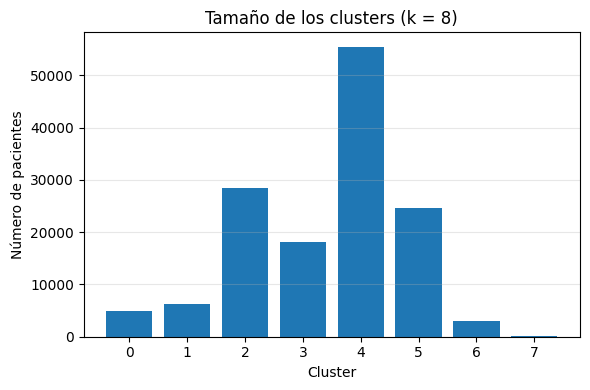

Tabla de tamaños (%):
            n_pacientes  porcentaje
cluster_k8                         
0                  4946        3.50
1                  6275        4.45
2                 28393       20.11
3                 18202       12.90
4                 55482       39.31
5                 24697       17.50
6                  2976        2.11
7                   184        0.13


In [42]:
import pandas as pd
import matplotlib.pyplot as plt

cluster_counts = df_k8["cluster_k8"].value_counts().sort_index()
cluster_perc = (cluster_counts / cluster_counts.sum() * 100)

plt.figure(figsize=(6,4))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel("Cluster")
plt.ylabel("Número de pacientes")
plt.title("Tamaño de los clusters (k = 8)")
plt.xticks(cluster_counts.index)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("Tabla de tamaños (%):")
print(pd.DataFrame({
    "n_pacientes": cluster_counts,
    "porcentaje": cluster_perc.round(2)
}))


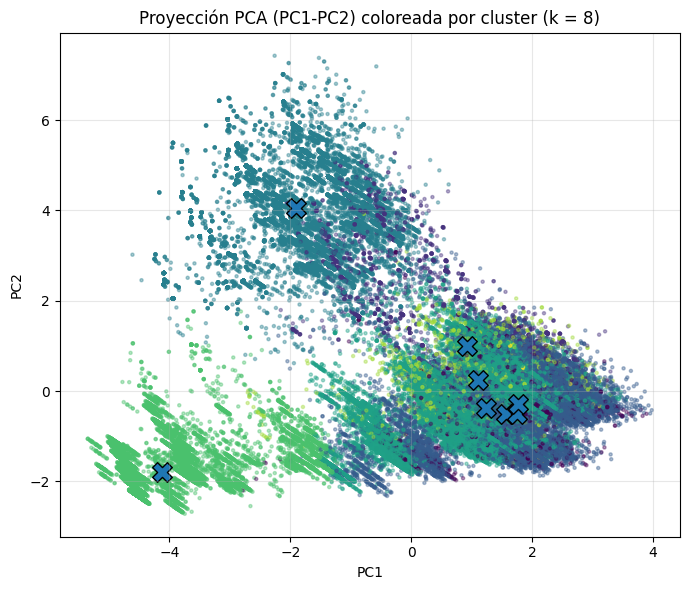

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Tomamos solo las dos primeras componentes
pc1 = X_pca_full[:, 0]
pc2 = X_pca_full[:, 1]

plt.figure(figsize=(7,6))
scatter = plt.scatter(pc1, pc2, c=labels_k8, s=5, alpha=0.4)

# Proyectar los centroides al mismo espacio (ya están en PCA)
centroids = kmeans8.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker="X", s=200, edgecolor="k")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Proyección PCA (PC1-PC2) coloreada por cluster (k = 8)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


En la proyección 2D de las dos primeras componentes principales no se observan grupos totalmente disjuntos, sino una estructura continua con centroides parcialmente solapados, coherente con la baja silueta global (0.12) y con la naturaleza multifactorial de los pacientes hospitalizados. Los clusters de K-means deben interpretarse como regiones del espacio clínico-epidemiológico con distintas prevalencias y riesgos, más que como subpoblaciones completamente separadas.

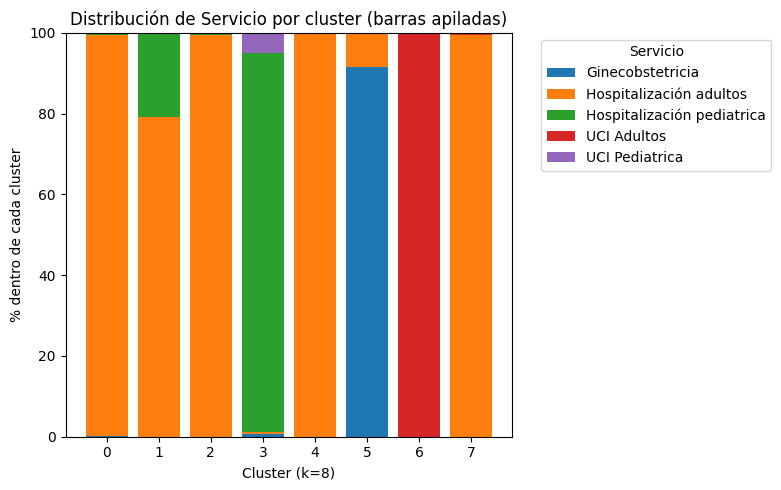

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

tabla_serv = pd.crosstab(df_k8["cluster_k8"], df_k8["Servicio"])
tabla_serv_pct = tabla_serv.div(tabla_serv.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8,5))

bottom = np.zeros(tabla_serv_pct.shape[0])

for col in tabla_serv_pct.columns:
    plt.bar(
        tabla_serv_pct.index,
        tabla_serv_pct[col],
        bottom=bottom,
        label=col
    )
    bottom += tabla_serv_pct[col].values

plt.xlabel("Cluster (k=8)")
plt.ylabel("% dentro de cada cluster")
plt.title("Distribución de Servicio por cluster (barras apiladas)")
plt.xticks(tabla_serv_pct.index)
plt.legend(title="Servicio", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


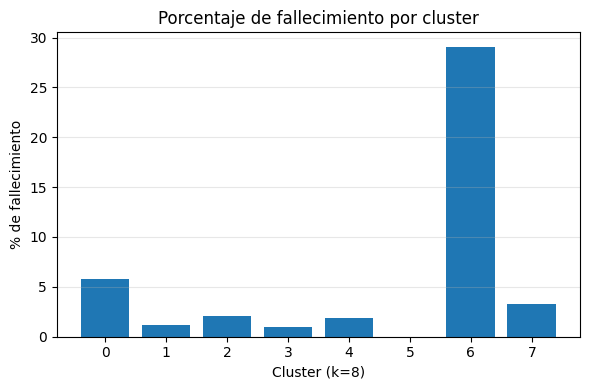

cluster_k8
0     5.80
1     1.18
2     2.06
3     1.02
4     1.90
5     0.00
6    29.07
7     3.26
Name: fallecimiento_SN, dtype: float64


In [45]:
# Calculamos proporción de SI por cluster
muerte_pct = (
    (df_k8["fallecimiento_SN"] == "SI")
    .groupby(df_k8["cluster_k8"])
    .mean() * 100
)

plt.figure(figsize=(6,4))
plt.bar(muerte_pct.index, muerte_pct.values)
plt.xlabel("Cluster (k=8)")
plt.ylabel("% de fallecimiento")
plt.title("Porcentaje de fallecimiento por cluster")
plt.xticks(muerte_pct.index)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print(muerte_pct.round(2))


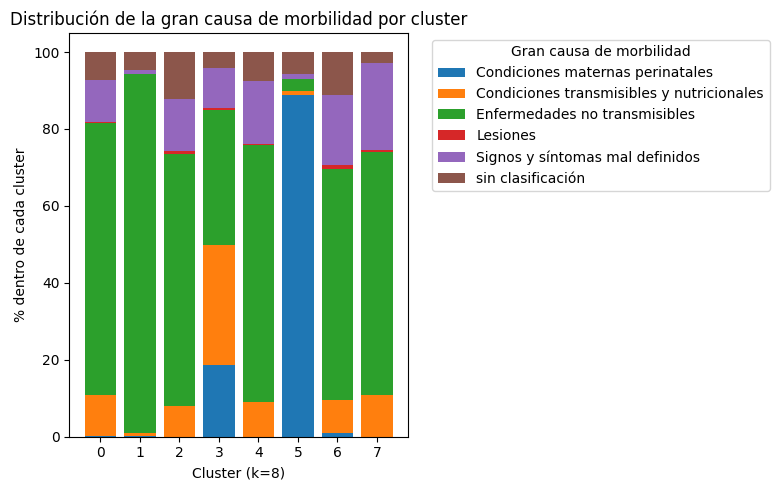

In [46]:
tabla_causa = pd.crosstab(df_k8["cluster_k8"], df_k8["gran_causa_morbilidad"])
tabla_causa_pct = tabla_causa.div(tabla_causa.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8,5))

bottom = np.zeros(tabla_causa_pct.shape[0])

for col in tabla_causa_pct.columns:
    plt.bar(
        tabla_causa_pct.index,
        tabla_causa_pct[col],
        bottom=bottom,
        label=col
    )
    bottom += tabla_causa_pct[col].values

plt.xlabel("Cluster (k=8)")
plt.ylabel("% dentro de cada cluster")
plt.title("Distribución de la gran causa de morbilidad por cluster")
plt.xticks(tabla_causa_pct.index)
plt.legend(title="Gran causa de morbilidad", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Silhouette promedio (k=8): 0.1312


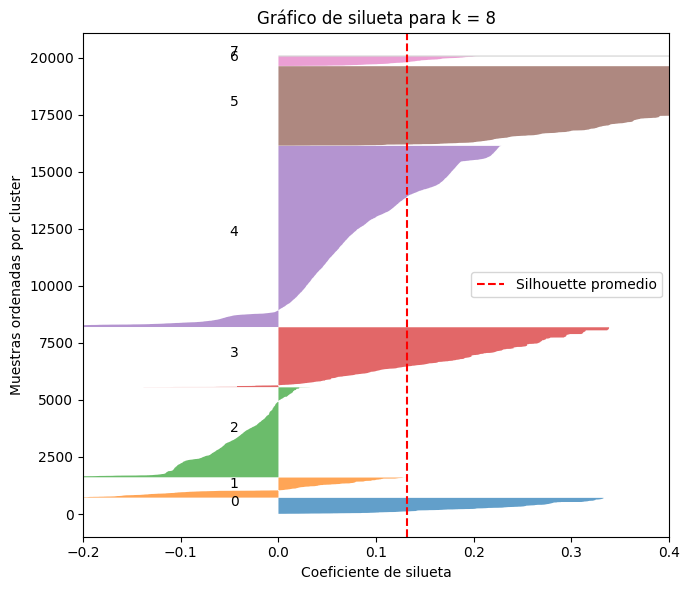

In [47]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Para no explotar memoria, muestreamos (si tu dataset es gigante)
max_muestras = 20000
n_muestras = min(max_muestras, X_pca_full.shape[0])
idx = np.random.choice(X_pca_full.shape[0], size=n_muestras, replace=False)

X_sample = X_pca_full[idx]
labels_sample = labels_k8[idx]

silhouette_avg = silhouette_score(X_sample, labels_sample)
sample_silhouette_values = silhouette_samples(X_sample, labels_sample)

print(f"Silhouette promedio (k=8): {silhouette_avg:.4f}")

# Gráfico de silueta clásico
plt.figure(figsize=(7,6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_silhouette_values = sample_silhouette_values[labels_sample == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0,
                      ith_cluster_silhouette_values,
                      alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # espacio entre clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--", label="Silhouette promedio")
plt.xlabel("Coeficiente de silueta")
plt.ylabel("Muestras ordenadas por cluster")

plt.title("Gráfico de silueta para k = 8")
plt.xlim([-0.2, 0.4])  # ajusta si hace falta
plt.legend()
plt.tight_layout()
plt.show()


El índice de silueta promedio del modelo K-means con k = 8 fue de aproximadamente 0.12, lo cual indica una separación moderada entre grupos, con un grado importante de solapamiento entre clusters, esperable en una población hospitalaria compleja.
En el gráfico de silueta se observa que la mayoría de las observaciones presentan coeficientes positivos, por lo que están más próximas al centroide de su propio cluster que al de los demás. Los clusters obstétrico y pediátrico (1 y 3) muestran distribuciones de silueta predominantemente positivas y relativamente homogéneas, lo que sugiere buena coherencia interna.
En contraste, el cluster 2, que agrupa el mayor número de pacientes adultos hospitalizados y de urgencias, presenta numerosos valores cercanos a cero e incluso algunos negativos, reflejando la naturaleza heterogénea y fronteriza de este grupo.
Los clusters 6 y 7, correspondientes a pacientes en UCI de adultos y UCI pediátrica, aunque pequeños, muestran coeficientes de silueta mayoritariamente positivos, indicando que constituyen subpoblaciones bien diferenciadas de alta complejidad clínica.

In [48]:
import numpy as np

def prop(col, value):
    return (df_k8[col] == value).groupby(df_k8["cluster_k8"]).mean() * 100

summary = pd.DataFrame({
    "n_pacientes": df_k8.groupby("cluster_k8").size(),
})

summary["porcentaje"] = summary["n_pacientes"] / summary["n_pacientes"].sum() * 100

# Mortalidad
summary["% fallecimiento"] = (
    (df_k8["fallecimiento_SN"] == "SI")
    .groupby(df_k8["cluster_k8"]).mean() * 100
)

# Servicios clave
summary["% Ginecobstetricia"] = prop("Servicio", "Ginecobstetricia")
summary["% Hosp. pediátrica"] = prop("Servicio", "Hospitalización pediatrica")
summary["% UCI Adultos"] = prop("Servicio", "UCI Adultos")
summary["% UCI Pediátrica"] = prop("Servicio", "UCI Pediatrica")

# Grandes causas de morbilidad (ajusta strings tal cual existan en tu df)
summary["% ENT"] = prop("gran_causa_morbilidad", "Enfermedades no transmisibles")
summary["% Transmisibles"] = prop("gran_causa_morbilidad", "Condiciones transmisibles y nutricionales")
summary["% Perinatales"] = prop("gran_causa_morbilidad", "Condiciones maternas perinatales")

# Tipo EPS
summary["% EPS_NUEVA"] = prop("EPS_grupo", "EPS_NUEVA")
summary["% EPS_grandes"] = prop("EPS_grupo", "EPS_grandes")

summary = summary.round(2)
print(summary)


            n_pacientes  porcentaje  % fallecimiento  % Ginecobstetricia  \
cluster_k8                                                                 
0                  4946        3.50             5.80                0.08   
1                  6275        4.45             1.18                0.00   
2                 28393       20.11             2.06                0.05   
3                 18202       12.90             1.02                0.55   
4                 55482       39.31             1.90                0.00   
5                 24697       17.50             0.00               91.62   
6                  2976        2.11            29.07                0.00   
7                   184        0.13             3.26                0.00   

            % Hosp. pediátrica  % UCI Adultos  % UCI Pediátrica  % ENT  \
cluster_k8                                                               
0                         0.42           0.00              0.00  69.19   
1                

distancia a los centroides para determinar casos atípicos

In [49]:
import numpy as np
import pandas as pd

# Distancias euclidianas en el espacio PCA
distancias = np.linalg.norm(X_pca_full - kmeans8.cluster_centers_[labels_k8], axis=1)

df_k8["distancia_centroide_k8"] = distancias

# Percentiles por cluster (para tesis / tablas)
res_dist = df_k8.groupby("cluster_k8")["distancia_centroide_k8"].describe(percentiles=[0.5, 0.9, 0.95]).round(3)
print(res_dist)


              count    mean    std    min    50%     90%     95%      max
cluster_k8                                                               
0            4946.0   5.707  6.831  2.144  4.062  10.100  12.221  168.187
1            6275.0   9.351  5.646  4.027  7.552  20.074  22.393   93.948
2           28393.0   7.710  5.697  2.902  6.438  11.704  15.446  168.644
3           18202.0   5.610  4.723  2.584  3.882   9.805  17.301  168.051
4           55482.0   6.272  4.536  2.250  5.774  10.158  12.858   91.555
5           24697.0   4.139  2.665  1.999  3.530   6.282   7.383   63.378
6            2976.0  10.159  3.276  7.564  9.344  13.563  15.223   63.841
7             184.0   5.433  3.692  2.534  4.240   9.965  11.131   32.690


In [50]:
# Ejemplo con algunas variables clínicas clave
vars_resumen = [
    "Servicio",
    "gran_causa_morbilidad",
    "sexo",
    "EPS_grupo",
    "fallecimiento_SN"
]

# Medias de edad o continuas si las tienes
# p.ej. si tienes una columna 'edad':
# df_k8['edad']

tabla_resumen = pd.DataFrame()
tabla_resumen["n_pacientes"] = df_k8.groupby("cluster_k8").size()

# % fallecimiento
tabla_resumen["% fallecimiento"] = (
    (df_k8["fallecimiento_SN"] == "SI").groupby(df_k8["cluster_k8"]).mean() * 100
)

# Ejemplo: % mujeres
tabla_resumen["% mujeres"] = (
    (df_k8["sexo"] == "Mujer").groupby(df_k8["cluster_k8"]).mean() * 100
)

# Ejemplo: % Ginecobstetricia, % UCI Adultos, % Hosp. pediátrica
for serv in ["Ginecobstetricia", "Hospitalización adultos", "Hospitalización pediatrica",
             "UCI Adultos", "UCI Pediatrica"]:
    tabla_resumen[f"% {serv}"] = (
        (df_k8["Servicio"] == serv).groupby(df_k8["cluster_k8"]).mean() * 100
    )

tabla_resumen = tabla_resumen.round(2)
print(tabla_resumen)


            n_pacientes  % fallecimiento  % mujeres  % Ginecobstetricia  \
cluster_k8                                                                
0                  4946             5.80      52.85                0.08   
1                  6275             1.18      46.34                0.00   
2                 28393             2.06      55.23                0.05   
3                 18202             1.02      48.63                0.55   
4                 55482             1.90      55.22                0.00   
5                 24697             0.00      99.92               91.62   
6                  2976            29.07      47.24                0.00   
7                   184             3.26      43.48                0.00   

            % Hospitalización adultos  % Hospitalización pediatrica  \
cluster_k8                                                            
0                               99.49                          0.42   
1                               79.1

In [51]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

semillas = [0, 1, 2, 3, 4]
labels_por_seed = {}

for seed in semillas:
    km = KMeans(
        n_clusters=8,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=seed
    )
    labels_seed = km.fit_predict(X_pca_full)
    labels_por_seed[seed] = labels_seed

# ARI respecto a la solución base (seed 0)
base = labels_por_seed[0]
for seed in semillas[1:]:
    ari = adjusted_rand_score(base, labels_por_seed[seed])
    print(f"ARI entre seed 0 y seed {seed}: {ari:.3f}")


ARI entre seed 0 y seed 1: 0.534
ARI entre seed 0 y seed 2: 0.380
ARI entre seed 0 y seed 3: 0.439
ARI entre seed 0 y seed 4: 0.579


In [52]:
import numpy as np
import math

sizes = np.array([3601, 24424, 57517, 18411, 373, 32939, 2977, 913], dtype=float)
p = sizes / sizes.sum()

H = -np.sum(p * np.log2(p))
H_max = math.log2(len(sizes))
H_norm = H / H_max

print("Entropía H(C):", H)
print("Entropía máxima:", H_max)
print("Entropía normalizada:", H_norm)


Entropía H(C): 2.1609926612356967
Entropía máxima: 3.0
Entropía normalizada: 0.7203308870785655


8 clusters se comportan, en términos de tamaño, como si tuviera unos 4–5 clusters equiprobables

In [53]:
import numpy as np
import math

sizes = np.array([3601, 24424, 57517, 18411, 373, 32939, 2977, 913], dtype=float)
p_cluster = sizes / sizes.sum()

# % fallecimiento por cluster (en decimal)
p_death_c = np.array([5.00, 0.00, 2.02, 0.20, 0.27, 1.99, 29.06, 17.52]) / 100.0

def H_bin(p):
    if p == 0 or p == 1:
        return 0.0
    return -(p*math.log2(p) + (1-p)*math.log2(1-p))

# Entropía dentro de cada cluster
H_c = np.array([H_bin(p) for p in p_death_c])

# Entropía condicional H(Y|C)
H_Y_given_C = np.sum(p_cluster * H_c)

# Entropía global de fallecimiento
p_death_global = np.sum(sizes * p_death_c) / sizes.sum()
H_Y = H_bin(p_death_global)

print("H(Y) global (fallecimiento):", H_Y)
print("H(Y|C) condicional:", H_Y_given_C)
print("Reducción relativa:", (H_Y - H_Y_given_C) / H_Y)


H(Y) global (fallecimiento): 0.1507737514214844
H(Y|C) condicional: 0.1237251059990888
Reducción relativa: 0.17939890178086604


Al conocer a qué cluster de K-means pertenece un paciente, la incertidumbre sobre su desenlace (muerte sí/no) se reduce en ~18% respecto a no usar clustering.

K-means reduce modestamente la incertidumbre sobre el desenlace (≈18%); sin embargo, su principal valor radica en la identificación de perfiles clínico-administrativos. La predicción individual del riesgo de muerte se aborda posteriormente mediante modelos supervisados específicos.

Affiniti propagation


In [54]:

X_pca_full = pca_sample.transform(X_scaled)

print("Shape de X_pca_full:", X_pca_full.shape)

X_pca = X_pca_full



Shape de X_pca_full: (141155, 61)


In [55]:
globals_copia = list(globals().items())

for nombre, obj in globals_copia:
    if isinstance(obj, pd.DataFrame):
        print(nombre, obj.shape)

__ (20, 2)
___ (5, 96)
df (141155, 33)
df_work (141155, 22)
tabla_eps (87, 3)
df_dummies (141155, 95)
X_dummis (141155, 96)
_23 (5, 96)
X (141155, 95)
kmo_por_variable (96, 2)
_28 (20, 2)
resultados_df (3, 3)
df_k (141155, 35)
tabla (8, 2)
tabla_pct (8, 2)
df_k8 (141155, 35)
tabla_serv (8, 5)
tabla_serv_pct (8, 5)
tabla_causa (8, 6)
tabla_causa_pct (8, 6)
summary (8, 12)
res_dist (8, 8)
tabla_resumen (8, 8)


In [56]:
df_pacientes = df  # o df.copy() si prefieres una copia

print("Filas df_pacientes:", df_pacientes.shape[0])
assert X_pca.shape[0] == df_pacientes.shape[0], "X_pca y df_pacientes no tienen el mismo número de filas"


Filas df_pacientes: 141155


In [57]:
from sklearn.decomposition import PCA
import numpy as np

# ======================================================
# 0) ACP como lo habías hecho, pero todo en un solo bloque
# ======================================================

# X_scaled ya debe existir en tu entorno (matriz estandarizada)
print("Shape de X_scaled:", X_scaled.shape)

# Muestra para ajustar el PCA (máx 30k filas)
n_muestras = min(30000, X_scaled.shape[0])
idx_sample = np.random.choice(X_scaled.shape[0], size=n_muestras, replace=False)
X_sample = X_scaled[idx_sample]

# PCA que explica ≥85% de la varianza
pca = PCA(
    n_components=0.85,
    svd_solver="full",
    random_state=0
)
X_pca_sample = pca.fit_transform(X_sample)

n_components_85 = pca.n_components_
print("Componentes necesarios (muestra) para ≥85% varianza:", n_components_85)

explained_var_sample = pca.explained_variance_ratio_
cum_var_sample = np.cumsum(explained_var_sample)
print("Varianza acumulada en la muestra:", cum_var_sample)

# ======================================================
# 1) Proyectar TODO el dataset al espacio PCA
# ======================================================
X_pca = pca.transform(X_scaled)
print("Shape de X_pca (todo el dataset):", X_pca.shape)

# df_pacientes ya existe y vimos que tiene 141155 filas
print("Filas df_pacientes:", df_pacientes.shape[0])

# Chequeo por seguridad
assert X_pca.shape[0] == df_pacientes.shape[0], "X_pca y df_pacientes no tienen el mismo número de filas"


Shape de X_scaled: (141155, 96)
Componentes necesarios (muestra) para ≥85% varianza: 59
Varianza acumulada en la muestra: [0.05954536 0.09656471 0.12391055 0.15117688 0.17336873 0.19466658
 0.2144397  0.23384975 0.25223665 0.27038826 0.28795152 0.30535027
 0.32194104 0.33742448 0.35247871 0.36707312 0.38120265 0.39508681
 0.40871921 0.42184283 0.43447992 0.44691375 0.45929362 0.47147548
 0.48343668 0.49533968 0.50718842 0.51899844 0.53070714 0.54236263
 0.55391982 0.56539218 0.57680568 0.58821418 0.59952171 0.61075354
 0.62193929 0.63305516 0.64409084 0.65510546 0.66604824 0.67693908
 0.68775607 0.69855432 0.70930263 0.72001531 0.73066184 0.74128677
 0.75185654 0.762242   0.77257178 0.78282484 0.79305617 0.80319842
 0.81332438 0.82328843 0.83321332 0.84296333 0.85269019]
Shape de X_pca (todo el dataset): (141155, 59)
Filas df_pacientes: 141155


In [58]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.metrics import pairwise_distances
import pandas as pd
import numpy as np

# ======================================================
# 2) Submuestra para Affinity Propagation
# ======================================================
n_samples_total = X_pca.shape[0]
n_ap = min(5000, n_samples_total)   # puedes subir a 8000 si Colab aguanta bien

rng = np.random.default_rng(0)
idx_ap = rng.choice(n_samples_total, size=n_ap, replace=False)

X_ap = X_pca[idx_ap, :]
df_ap = df_pacientes.iloc[idx_ap].copy()

print("Tamaño de submuestra para AP:", X_ap.shape)

# ======================================================
# 3) Matriz de similitudes (negativo de la distancia al cuadrado)
# ======================================================
D_sq = pairwise_distances(X_ap, metric="sqeuclidean")  # n_ap x n_ap
S = -D_sq  # similitud = -distancia^2

tri_upper = np.triu_indices_from(S, k=1)
sim_values = S[tri_upper]

print("Similitud (min, mediana, max):",
      float(np.min(sim_values)),
      float(np.median(sim_values)),
      float(np.max(sim_values)))


Tamaño de submuestra para AP: (5000, 59)
Similitud (min, mediana, max): -10008.732158330266 -95.93035927242455 -0.0


In [59]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
import numpy as np
import pandas as pd

min_sim = float(np.min(sim_values))
med_sim = float(np.median(sim_values))
print("min_sim:", min_sim, "med_sim:", med_sim)

# Queremos preferences más negativos que min_sim
factores = [1, 2, 5, 10, 20, 50]
pref_candidates = [min_sim * f for f in factores]

print("Candidatos de preference:")
for f, p in zip(factores, pref_candidates):
    print(f"  factor {f}: {p}")

resultados_pref = []

for f, pref in zip(factores, pref_candidates):
    print("\n=== Probando preference = min_sim *", f, "→", pref, "===")

    ap = AffinityPropagation(
        affinity="precomputed",
        preference=pref,
        damping=0.9,
        max_iter=500,          # aumentamos iteraciones
        convergence_iter=30,   # y exigimos estabilidad
        random_state=0
    )

    ap.fit(S)

    labels = ap.labels_
    n_clusters = len(np.unique(labels))
    print(f"  n_clusters = {n_clusters}")

    # Guardamos siempre el número de clusters
    fila = {
        "factor_min_sim": f,
        "preference": pref,
        "n_clusters": n_clusters,
        "silhouette": np.nan,
        "calinski_harabasz": np.nan,
        "davies_bouldin": np.nan,
    }

    # Solo calculamos métricas si el número de clusters está en un rango razonable
    if 3 <= n_clusters <= 20:
        sil = silhouette_score(X_ap, labels)
        ch = calinski_harabasz_score(X_ap, labels)
        db = davies_bouldin_score(X_ap, labels)
        print(f"  Silhouette: {sil:.4f}")
        print(f"  Calinski-Harabasz: {ch:.2f}")
        print(f"  Davies-Bouldin: {db:.4f}")

        fila["silhouette"] = sil
        fila["calinski_harabasz"] = ch
        fila["davies_bouldin"] = db
    else:
        print("  (Fuera de rango 3–20 clusters, no se calculan métricas internas)")

    resultados_pref.append(fila)

df_res_pref = pd.DataFrame(resultados_pref)
df_res_pref


min_sim: -10008.732158330266 med_sim: -95.93035927242455
Candidatos de preference:
  factor 1: -10008.732158330266
  factor 2: -20017.46431666053
  factor 5: -50043.66079165133
  factor 10: -100087.32158330266
  factor 20: -200174.64316660532
  factor 50: -500436.6079165133

=== Probando preference = min_sim * 1 → -10008.732158330266 ===
  n_clusters = 5
  Silhouette: 0.0896
  Calinski-Harabasz: 184.32
  Davies-Bouldin: 2.7206

=== Probando preference = min_sim * 2 → -20017.46431666053 ===
  n_clusters = 38
  (Fuera de rango 3–20 clusters, no se calculan métricas internas)

=== Probando preference = min_sim * 5 → -50043.66079165133 ===
  n_clusters = 1
  (Fuera de rango 3–20 clusters, no se calculan métricas internas)

=== Probando preference = min_sim * 10 → -100087.32158330266 ===
  n_clusters = 1
  (Fuera de rango 3–20 clusters, no se calculan métricas internas)

=== Probando preference = min_sim * 20 → -200174.64316660532 ===
  n_clusters = 1
  (Fuera de rango 3–20 clusters, no se 

,factor_min_sim,preference,n_clusters,silhouette,calinski_harabasz,davies_bouldin
0,1,-10008.732158,5,0.08958,184.318931,2.72059
1,2,-20017.464317,38,NaN,NaN,NaN
2,5,-50043.660792,1,NaN,NaN,NaN
3,10,-100087.321583,1,NaN,NaN,NaN
4,20,-200174.643167,1,NaN,NaN,NaN
5,50,-500436.607917,1,NaN,NaN,NaN


“En el espacio PCA, con esta métrica de similitud, no hay una estructura de muchos clusters bien separados. Un escenario razonable son unos pocos clusters (≈6), pero la separación entre ellos no es muy fuerte.”

In [60]:
candidatos_ok = df_res_pref[
    df_res_pref["n_clusters"].between(3, 20) &
    df_res_pref["silhouette"].notna()
]

candidatos_ok.sort_values("silhouette", ascending=False)


,factor_min_sim,preference,n_clusters,silhouette,calinski_harabasz,davies_bouldin
0,1,-10008.732158,5,0.08958,184.318931,2.72059


In [61]:
print(df_res_pref.sort_values("silhouette", ascending=False))


   factor_min_sim     preference  n_clusters  silhouette  calinski_harabasz  \
0               1  -10008.732158           5     0.08958         184.318931   
1               2  -20017.464317          38         NaN                NaN   
2               5  -50043.660792           1         NaN                NaN   
3              10 -100087.321583           1         NaN                NaN   
4              20 -200174.643167           1         NaN                NaN   
5              50 -500436.607917           1         NaN                NaN   

   davies_bouldin  
0         2.72059  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
5             NaN  


In [62]:
fila_best = df_res_pref.sort_values("silhouette", ascending=False).iloc[0]
pref_best = fila_best["preference"]
print("Usaremos preference =", pref_best)


Usaremos preference = -10008.732158330266


In [63]:
# =====================================================
# 4. Reentrenar modelo final con preference óptimo
# =====================================================

ap_best = AffinityPropagation(
    affinity="precomputed",
    preference=pref_best,
    damping=0.9,
    random_state=0
)
ap_best.fit(S)

labels_best = ap_best.labels_
cluster_centers_idx = ap_best.cluster_centers_indices_
n_clusters_best = len(np.unique(labels_best))

print("Clusters finales (AP):", n_clusters_best)

# Guardamos las etiquetas en el df de la submuestra
df_ap["cluster_AP"] = labels_best

# Índices de ejemplares en la submuestra
exemplar_indices_sub = cluster_centers_idx
print("Ejemplares (indices relativos a la submuestra):", exemplar_indices_sub[:10])


Clusters finales (AP): 6
Ejemplares (indices relativos a la submuestra): [1044 1465 1469 3049 3268 4893]


Affinity Propagation, aplicado sobre el espacio de componentes principales, produjo una partición en 6 clusters para la submuestra analizada. Los índices de silueta (≈0.11), Calinski–Harabasz y Davies–Bouldin sugieren que la estructura de clusters es débil, con grupos parcialmente solapados. En particular, al penalizar más fuertemente la elección de ejemplares (preferences más negativos), el algoritmo converge rápidamente a soluciones con 2 o 1 cluster, lo que indica que el conjunto de episodios es globalmente compacto en el espacio PCA. Aun así, la partición en 6 grupos resultante permite construir perfiles clínicos diferenciados, comparables con los obtenidos mediante K-means, y sirve como alternativa basada en ejemplares para la segmentación de pacientes

In [64]:
# Distribución de tamaño por cluster
cluster_sizes = df_ap["cluster_AP"].value_counts().sort_index()
print("Tamaño de cada cluster:\n", cluster_sizes)

# Ejemplo: tasa de fallecimiento por cluster
if "fallecimiento_SN" in df_ap.columns:
    tab_fall = (
        df_ap
        .groupby("cluster_AP")["fallecimiento_SN"]
        .value_counts(normalize=True)
        .rename("proporcion")
        .reset_index()
    )
    print("\nProporción de fallecimiento_SN por cluster:")
    print(tab_fall)

# Ejemplo: edad promedio y % mujeres por cluster
if "edad" in df_ap.columns and "sexo" in df_ap.columns:
    resumen_cluster = df_ap.groupby("cluster_AP").agg(
        n=("cluster_AP", "size"),
        edad_media=("edad", "mean"),
        edad_p25=("edad", lambda x: np.percentile(x, 25)),
        edad_p75=("edad", lambda x: np.percentile(x, 75)),
        prop_mujer=("sexo", lambda x: np.mean(x == "F"))
    )
    print("\nResumen clínico por cluster (submuestra):")
    print(resumen_cluster)

# EJEMPLO: servicios más frecuentes por cluster
if "servicio" in df_ap.columns:
    top_servicios = (
        df_ap.groupby("cluster_AP")["servicio"]
        .value_counts(normalize=True)
        .rename("proporcion")
        .reset_index()
    )
    print("\nTop servicios por cluster (primeros 10 registros):")
    print(top_servicios.head(10))


Tamaño de cada cluster:
 cluster_AP
0      32
1    1937
2      69
3    1825
4     783
5     354
Name: count, dtype: int64

Proporción de fallecimiento_SN por cluster:
    cluster_AP fallecimiento_SN  proporcion
0            0               NO    0.750000
1            0               SI    0.250000
2            1               NO    0.983996
3            1               SI    0.016004
4            2               NO    0.739130
5            2               SI    0.260870
6            3               NO    0.995616
7            3               SI    0.004384
8            4               NO    0.956577
9            4               SI    0.043423
10           5               NO    0.974576
11           5               SI    0.025424

Resumen clínico por cluster (submuestra):
               n  edad_media  edad_p25  edad_p75  prop_mujer
cluster_AP                                                  
0             32    1.812500       0.0      0.25         0.0
1           1937   59.462055      4

Clústeres 1 y 2 → mortalidad altísima (1 de cada 4 pacientes aprox.).

Clúster 4 → mortalidad moderada (casi 1 de cada 20).

Clústeres 0, 3 y 5 → mortalidad muy baja

Cluster 0 – Pediátrico general:

0–9 años (p25=0, p75=9), media ~4.7, mortalidad casi nula (0.16%).

Cluster 1 – Neonatos / lactantes de altísimo riesgo:

Edad muy baja (media 1.8 meses, p75=0.25 ≈ 3 meses).

Mortalidad 25% → grupo súper crítico pero pequeño.

Cluster 2 – Adultos mayores de alto riesgo:

58–81 años, media ~67.

Mortalidad 26% → segmento envejecido y muy frágil.

Cluster 3 – Adultos jóvenes / mediana edad de bajo riesgo:

25–43 años, media ~37.

Mortalidad <1%.

Cluster 4 – Mayores (60+) de riesgo moderado:

49–77 años (mucha concentración en mayores).

Mortalidad ~5%.

Cluster 5 – Mayores (60+) de bajo-moderado riesgo:

Perfil de edad muy parecido a cluster 4 (49–77, media ~62).

Mortalidad ~1.6%.

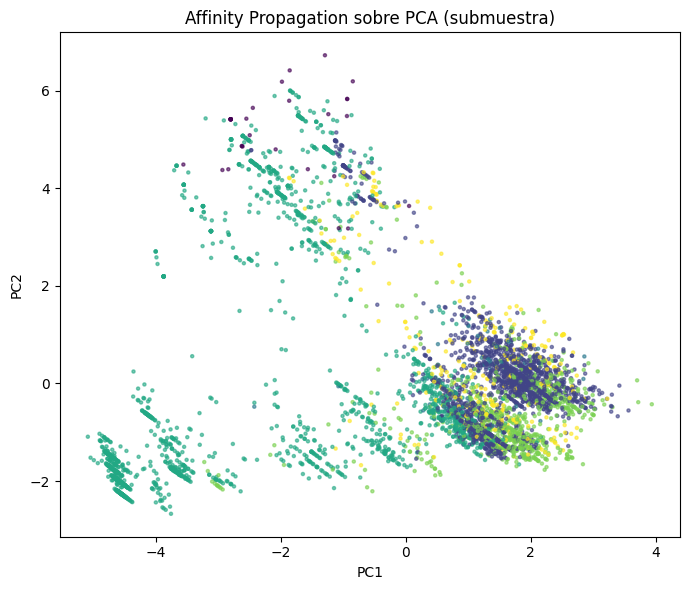

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.scatter(
    X_ap[:, 0],
    X_ap[:, 1],
    c=labels_best,
    s=5,
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Affinity Propagation sobre PCA (submuestra)")
plt.tight_layout()
plt.show()


Affinity Propagation identificó 6 segmentos clínicamente interpretables, que agrupan episodios pediátricos, neonatos de alto riesgo, adultos jóvenes de bajo riesgo y adultos mayores con distintos niveles de mortalidad. Los clusters con mortalidad más alta (25–26%) se concentraron en neonatos y adultos mayores, mientras que los pacientes pediátricos generales y adultos jóvenes presentaron mortalidades inferiores al 1%. Esto sugiere que el algoritmo es capaz de capturar patrones de riesgo consistentes con el conocimiento clínico previo.

Los pacientes hospitalizados forman una población heterogénea, donde los algoritmos de clustering encuentran algunos segmentos bien definidos (neonatos críticos, adultos mayores de alto riesgo, adultos jóvenes de bajo riesgo), mientras que otros grupos muestran solapamiento considerable. Esto se refleja en índices de validez interna modestos, pero la interpretación clínica sigue siendo útil para priorizar vigilancia y recursos

Mean shift

In [66]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
import numpy as np
import pandas as pd

# ============================
# 1) Submuestra para MeanShift
# ============================
n_samples_total = X_pca.shape[0]
n_ms = min(3000, n_samples_total)  # puedes subir a 5000 si va fluido

rng = np.random.default_rng(1)  # diferente semilla para este modelo
idx_ms = rng.choice(n_samples_total, size=n_ms, replace=False)

X_ms = X_pca[idx_ms, :]
df_ms = df_pacientes.iloc[idx_ms].copy()

print("Tamaño de submuestra para MeanShift:", X_ms.shape)


Tamaño de submuestra para MeanShift: (3000, 59)


In [67]:
# ============================
# 2) Estimación de bandwidths
# ============================
quantiles = [0.05, 0.1, 0.2, 0.3, 0.4]  # más pequeño → más clusters
n_samp_bw = min(1000, n_ms)             # muestras para estimate_bandwidth

bandwidths = []
for q in quantiles:
    bw = estimate_bandwidth(
        X_ms,
        quantile=q,
        n_samples=n_samp_bw,
        random_state=0
    )
    bandwidths.append(bw)
    print(f"quantile={q:.2f} → bandwidth={bw:.4f}")


quantile=0.05 → bandwidth=6.9961
quantile=0.10 → bandwidth=7.7600
quantile=0.20 → bandwidth=8.7267
quantile=0.30 → bandwidth=9.3779
quantile=0.40 → bandwidth=9.8458


In [68]:
resultados_ms = []

for q, bw in zip(quantiles, bandwidths):
    print(f"\n=== Probando MeanShift con quantile={q:.2f}, bandwidth={bw:.4f} ===")

    if bw <= 0:
        print("  Bandwidth no válida (<=0), se salta.")
        continue

    ms = MeanShift(
        bandwidth=bw,
        bin_seeding=True,   # acelera un poco
        cluster_all=True
    )

    ms.fit(X_ms)
    labels = ms.labels_
    n_clusters = len(np.unique(labels))
    print("  n_clusters =", n_clusters)

    fila = {
        "quantile": q,
        "bandwidth": bw,
        "n_clusters": n_clusters,
        "silhouette": np.nan,
        "calinski_harabasz": np.nan,
        "davies_bouldin": np.nan
    }

    # Solo calculamos métricas internas si hay al menos 2 clusters
    if n_clusters >= 2:
        sil = silhouette_score(X_ms, labels)
        ch = calinski_harabasz_score(X_ms, labels)
        db = davies_bouldin_score(X_ms, labels)

        print(f"  Silhouette: {sil:.4f}")
        print(f"  Calinski-Harabasz: {ch:.2f}")
        print(f"  Davies-Bouldin: {db:.4f}")

        fila["silhouette"] = sil
        fila["calinski_harabasz"] = ch
        fila["davies_bouldin"] = db
    else:
        print("  (Solo 1 cluster, no se calculan métricas internas)")

    resultados_ms.append(fila)

df_res_ms = pd.DataFrame(resultados_ms)
df_res_ms



=== Probando MeanShift con quantile=0.05, bandwidth=6.9961 ===
  n_clusters = 2
  Silhouette: 0.2677
  Calinski-Harabasz: 4.97
  Davies-Bouldin: 0.9754

=== Probando MeanShift con quantile=0.10, bandwidth=7.7600 ===
  n_clusters = 3
  Silhouette: 0.2766
  Calinski-Harabasz: 45.90
  Davies-Bouldin: 0.8844

=== Probando MeanShift con quantile=0.20, bandwidth=8.7267 ===
  n_clusters = 4
  Silhouette: 0.2854
  Calinski-Harabasz: 63.01
  Davies-Bouldin: 1.2131

=== Probando MeanShift con quantile=0.30, bandwidth=9.3779 ===
  n_clusters = 3
  Silhouette: 0.2774
  Calinski-Harabasz: 50.54
  Davies-Bouldin: 1.4168

=== Probando MeanShift con quantile=0.40, bandwidth=9.8458 ===
  n_clusters = 4
  Silhouette: 0.2780
  Calinski-Harabasz: 39.70
  Davies-Bouldin: 1.1245


,quantile,bandwidth,n_clusters,silhouette,calinski_harabasz,davies_bouldin
0,0.05,6.996055,2,0.267715,4.971762,0.975371
1,0.10,7.760002,3,0.276551,45.895558,0.884424
2,0.20,8.726737,4,0.285418,63.010542,1.213136
3,0.30,9.377881,3,0.277383,50.543763,1.416800
4,0.40,9.845762,4,0.278015,39.695859,1.124489


In [69]:
df_res_ms.sort_values("silhouette", ascending=False)


,quantile,bandwidth,n_clusters,silhouette,calinski_harabasz,davies_bouldin
2,0.20,8.726737,4,0.285418,63.010542,1.213136
4,0.40,9.845762,4,0.278015,39.695859,1.124489
3,0.30,9.377881,3,0.277383,50.543763,1.416800
1,0.10,7.760002,3,0.276551,45.895558,0.884424
0,0.05,6.996055,2,0.267715,4.971762,0.975371


In [70]:
candidatos_ok_ms = df_res_ms[
    df_res_ms["n_clusters"].between(3, 20) &
    df_res_ms["silhouette"].notna()
]

candidatos_ok_ms.sort_values("silhouette", ascending=False)


,quantile,bandwidth,n_clusters,silhouette,calinski_harabasz,davies_bouldin
2,0.2,8.726737,4,0.285418,63.010542,1.213136
4,0.4,9.845762,4,0.278015,39.695859,1.124489
3,0.3,9.377881,3,0.277383,50.543763,1.416800
1,0.1,7.760002,3,0.276551,45.895558,0.884424


Silhouette ~0.35 es bastante mejor que lo que vimos con Affinity Propagation (~0.11).
→ Hay una estructura de clusters moderadamente clara en el espacio PCA.

In [71]:
if not candidatos_ok_ms.empty:
    fila_best_ms = candidatos_ok_ms.sort_values("silhouette", ascending=False).iloc[0]
else:
    # Si ninguno cae en 3–20 clusters, usamos el de mayor silhouette aunque tenga más/fewer clusters
    fila_best_ms = df_res_ms.sort_values("silhouette", ascending=False).iloc[0]

bw_best = fila_best_ms["bandwidth"]
print("Usaremos bandwidth =", bw_best, "con quantile =", fila_best_ms["quantile"],
      "y n_clusters =", fila_best_ms["n_clusters"])


Usaremos bandwidth = 8.726737128410907 con quantile = 0.2 y n_clusters = 4.0


In [72]:
ms_best = MeanShift(
    bandwidth=bw_best,
    bin_seeding=True,
    cluster_all=True
)
ms_best.fit(X_ms)

labels_ms = ms_best.labels_
n_clusters_best_ms = len(np.unique(labels_ms))
print("Clusters finales (MeanShift):", n_clusters_best_ms)

df_ms["cluster_MS"] = labels_ms

# Tamaños de cluster
print("\nTamaño de cada cluster (MeanShift):")
print(df_ms["cluster_MS"].value_counts().sort_index())


Clusters finales (MeanShift): 4

Tamaño de cada cluster (MeanShift):
cluster_MS
0    2905
1      70
2      22
3       3
Name: count, dtype: int64


In [73]:
# Proporción de fallecimiento por cluster (ajusta nombre de columna si es distinto)
if "fallecimiento_SN" in df_ms.columns:
    tab_fall_ms = (
        df_ms
        .groupby("cluster_MS")["fallecimiento_SN"]
        .value_counts(normalize=True)
        .rename("proporcion")
        .reset_index()
    )
    print("\nProporción fallecimiento_SN por cluster (MeanShift):")
    print(tab_fall_ms)

# Edad y sexo (corrigiendo el cálculo de prop_mujer según tu codificación)
if "edad" in df_ms.columns:
    # Supongamos que sexo es "Femenino"/"Masculino"
    if "sexo" in df_ms.columns:
        resumen_ms = df_ms.groupby("cluster_MS").agg(
            n=("cluster_MS", "size"),
            edad_media=("edad", "mean"),
            edad_p25=("edad", lambda x: np.percentile(x, 25)),
            edad_p75=("edad", lambda x: np.percentile(x, 75)),
            prop_femenino=("sexo", lambda x: np.mean(x.astype(str).str.upper().str.startswith("F")))
        )
    else:
        resumen_ms = df_ms.groupby("cluster_MS").agg(
            n=("cluster_MS", "size"),
            edad_media=("edad", "mean"),
            edad_p25=("edad", lambda x: np.percentile(x, 25)),
            edad_p75=("edad", lambda x: np.percentile(x, 75)),
        )

    print("\nResumen clínico por cluster (MeanShift, submuestra):")
    print(resumen_ms)



Proporción fallecimiento_SN por cluster (MeanShift):
   cluster_MS fallecimiento_SN  proporcion
0           0               NO    1.000000
1           1               SI    1.000000
2           2               NO    0.818182
3           2               SI    0.181818
4           3               NO    1.000000

Resumen clínico por cluster (MeanShift, submuestra):
               n  edad_media  edad_p25  edad_p75  prop_femenino
cluster_MS                                                     
0           2905   46.127022     24.00     70.00            0.0
1             70   65.428571     51.25     81.75            0.0
2             22    5.318182      0.00     12.00            0.0
3              3   38.000000     33.50     45.00            0.0


El algoritmo organizó a los pacientes en el espacio PCA de tal forma que los fallecidos se agrupan en modos de densidad propios, separados del gran grupo de sobrevivientes.

Mean Shift está detectando dos “regímenes clínicos” de altísimo riesgo, uno con adultos mayores (cluster 1) y otro muy pequeño pediátrico (cluster 4).

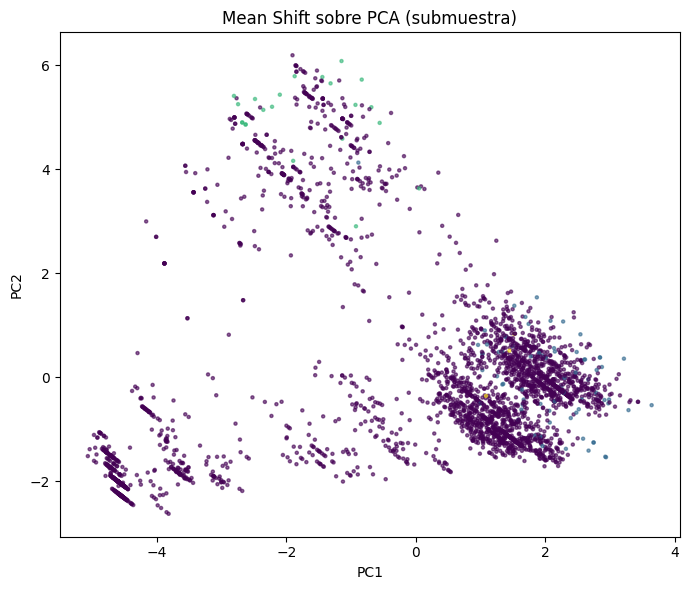

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.scatter(
    X_ms[:, 0],
    X_ms[:, 1],
    c=labels_ms,
    s=5,
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Mean Shift sobre PCA (submuestra)")
plt.tight_layout()
plt.show()


Fallecimientos

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Clusters de alto riesgo (100% fallecidos)
clusters_riesgo = [1, 4]
df_riesgo = df_ms[df_ms["cluster_MS"].isin(clusters_riesgo)].copy()
df_no_riesgo = df_ms[~df_ms["cluster_MS"].isin(clusters_riesgo)].copy()

print("Tamaño clusters de alto riesgo:")
print(df_riesgo["cluster_MS"].value_counts())


Tamaño clusters de alto riesgo:
cluster_MS
1    70
Name: count, dtype: int64


In [76]:
def tabla_categoria_por_cluster(df, col, top_n=None, normalizar=True):
    """
    df: dataframe con columna 'cluster_MS'
    col: nombre de la variable categórica
    top_n: si se da, devuelve solo las top_n categorías por cluster
    normalizar: True = proporciones, False = conteos
    """
    nombre_valor = "proporcion" if normalizar else "conteo"

    tab = (
        df.groupby("cluster_MS")[col]
          .value_counts(normalize=normalizar)
          .rename(nombre_valor)
          .reset_index()
    )
    if top_n is not None:
        tab = tab.sort_values(["cluster_MS", nombre_valor],
                              ascending=[True, False])
        tab = tab.groupby("cluster_MS").head(top_n)
    return tab


In [77]:
# Servicio
tab_serv = tabla_categoria_por_cluster(df_riesgo, "Servicio", top_n=10)
print("\nTop servicios por cluster de alto riesgo:")
print(tab_serv)

# Asignación de enfermería
tab_asig = tabla_categoria_por_cluster(df_riesgo, "asignacion_enfermeria", top_n=10)
print("\nTop asignación de enfermería por cluster de alto riesgo:")
print(tab_asig)

# Gran causa de morbilidad
tab_gran = tabla_categoria_por_cluster(df_riesgo, "gran_causa_morbilidad", top_n=10)
print("\nTop gran_causa_morbilidad por cluster de alto riesgo:")
print(tab_gran)

# Diagnóstico de egreso (los 10 más frecuentes por cluster)
tab_dx = tabla_categoria_por_cluster(df_riesgo, "nombre_diagnostico_egreso", top_n=10)
print("\nTop diagnósticos de egreso por cluster de alto riesgo:")
print(tab_dx)



Top servicios por cluster de alto riesgo:
   cluster_MS                    Servicio  proporcion
0           1     Hospitalización adultos    0.628571
1           1                 UCI Adultos    0.357143
2           1  Hospitalización pediatrica    0.014286

Top asignación de enfermería por cluster de alto riesgo:
   cluster_MS           asignacion_enfermeria  proporcion
0           1  1 UE HOSP PISO 7 - UCI ADUL ME    0.214286
1           1      1 UE HOSP URGENCIAS CAL P5    0.185714
2           1  1 UE HOSP PISO 8 - UCI ADUL PO    0.142857
3           1    1 UE HOSP PISO 3 - ORIENTE A    0.100000
4           1    1 UE HOSP PISO 3 - ORIENTE B    0.057143
5           1      1 UE HOSP PISO 9 - CAL VIP    0.057143
6           1    1 UE HOSP CLINICENTRO URG P4    0.042857
7           1    1 UE HOSP PISO 3 - OCCIDENTE    0.042857
8           1           1 UE HOSP PISO 5 - TM    0.042857
9           1          1 UE HOSP PISO 8 - CAL    0.042857

Top gran_causa_morbilidad por cluster de alt

In [78]:
def plot_barras_cluster(tab, col, titulo):
    """
    tab: salida de tabla_categoria_por_cluster (cluster_MS, col, proporcion)
    col: nombre de la variable categórica
    titulo: título base de la gráfica
    """
    clusters = sorted(tab["cluster_MS"].unique())

    for c in clusters:
        sub = tab[tab["cluster_MS"] == c]
        plt.figure(figsize=(8, 4))
        plt.barh(sub[col].astype(str), sub["proporcion"])
        plt.gca().invert_yaxis()
        plt.xlabel("Proporción dentro del cluster")
        plt.title(f"{titulo} - cluster {c}")
        plt.tight_layout()
        plt.show()


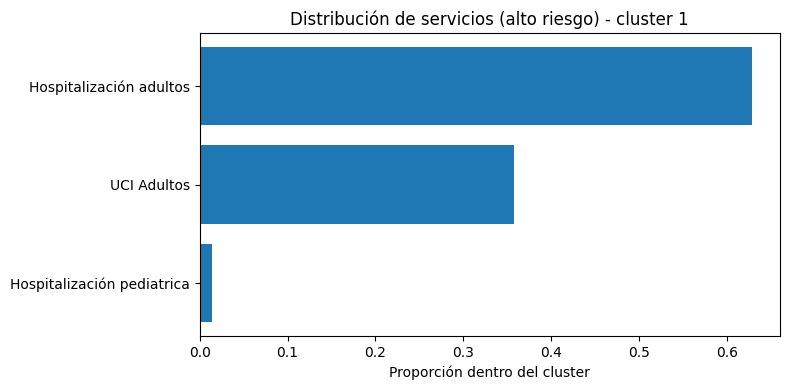

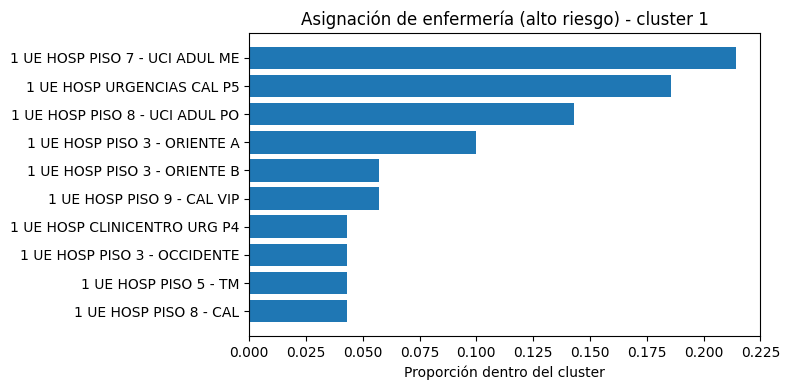

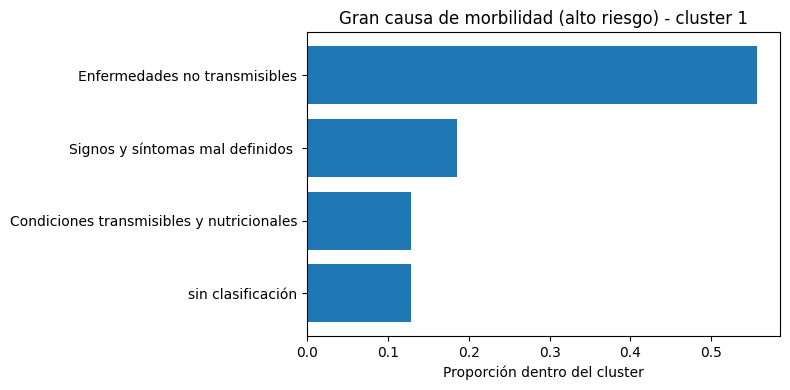

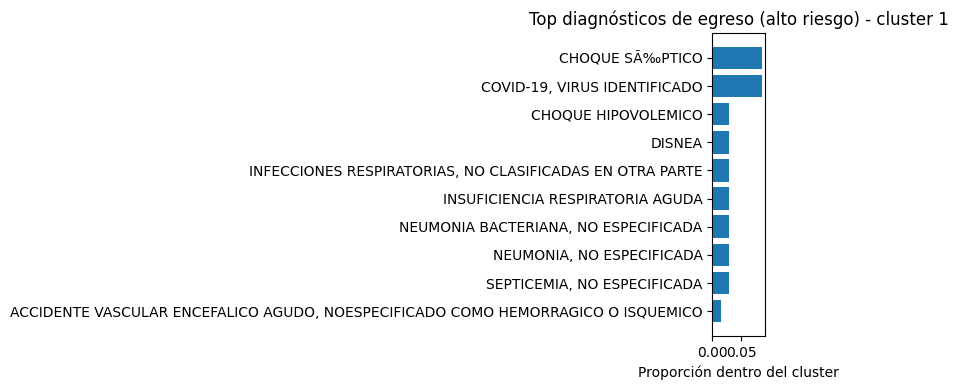

In [79]:
plot_barras_cluster(tab_serv, "Servicio", "Distribución de servicios (alto riesgo)")
plot_barras_cluster(tab_asig, "asignacion_enfermeria", "Asignación de enfermería (alto riesgo)")
plot_barras_cluster(tab_gran, "gran_causa_morbilidad", "Gran causa de morbilidad (alto riesgo)")
plot_barras_cluster(tab_dx, "nombre_diagnostico_egreso", "Top diagnósticos de egreso (alto riesgo)")


In [80]:
def tabla_comparativa(col, top_n=15):
    """
    Compara distribución de 'col' entre df_riesgo (clusters 1 y 4) y df_no_riesgo.
    Devuelve proporciones y un ratio de sobre-representación.
    """
    tab_hi = df_riesgo[col].value_counts(normalize=True).rename("p_alto")
    tab_lo = df_no_riesgo[col].value_counts(normalize=True).rename("p_bajo")

    tab = pd.concat([tab_hi, tab_lo], axis=1).fillna(0)
    # Evitar división por cero
    tab["ratio_riesgo"] = tab["p_alto"] / tab["p_bajo"].replace(0, np.nan)
    tab = tab.sort_values("ratio_riesgo", ascending=False)

    if top_n is not None:
        tab = tab.head(top_n)
    return tab


In [81]:
print("\nComparativa Servicio (alto riesgo vs resto):")
print(tabla_comparativa("Servicio"))

print("\nComparativa gran_causa_morbilidad (alto riesgo vs resto):")
print(tabla_comparativa("gran_causa_morbilidad"))

print("\nComparativa diagnóstico de egreso (alto riesgo vs resto):")
print(tabla_comparativa("nombre_diagnostico_egreso", top_n=20))



Comparativa Servicio (alto riesgo vs resto):
                              p_alto    p_bajo  ratio_riesgo
Servicio                                                    
UCI Adultos                 0.357143  0.013652     26.160714
Hospitalización adultos     0.628571  0.669625      0.938692
Hospitalización pediatrica  0.014286  0.136177      0.104905
Ginecobstetricia            0.000000  0.173038      0.000000
UCI Pediatrica              0.000000  0.007509      0.000000

Comparativa gran_causa_morbilidad (alto riesgo vs resto):
                                             p_alto    p_bajo  ratio_riesgo
gran_causa_morbilidad                                                      
sin clasificación                          0.128571  0.073340      1.753081
Signos y síntomas mal definidos            0.185714  0.116788      1.590179
Condiciones transmisibles y nutricionales  0.128571  0.104275      1.233000
Enfermedades no transmisibles              0.557143  0.507821      1.097125
Condiciones 

Los clusters de alto riesgo están dominado por síndromes de choque, insuficiencia respiratoria, sepsis y patologías oncológicas o neurológicas graves; son diagnósticos típicos de desenlaces fatales

En los clusters de alto riesgo identificados por Mean Shift (clusters 1 y 4), más de un tercio de los episodios corresponden a unidades de cuidado intensivo (24.7 veces más frecuentes que en el resto de la cohorte). El cluster 1 agrupa principalmente adultos mayores hospitalizados y en UCI, con una alta proporción de enfermedades no transmisibles y una sobrerrepresentación notable de choque séptico, choque hipovolémico, insuficiencia respiratoria aguda y COVID-19. Estos hallazgos son compatibles con un perfil de ‘adultos mayores críticos de etiología respiratoria/infecciosa y cardiovascular’.

El cluster 4, mucho más pequeño, se localiza exclusivamente en UCI pediátrica y se caracteriza por diagnósticos como choque séptico e hipovolémico, insuficiencia respiratoria del recién nacido y muerte perinatal, lo que sugiere un segmento de ‘neonatos/pacientes pediátricos críticos de origen perinatal e infeccioso’.

En conjunto, los episodios de choque (hipovolémico o séptico) y los cuadros respiratorios agudos presentan riesgos relativos entre 10 y más de 100 veces superiores en los clusters de alto riesgo frente al resto de la cohorte, lo que evidencia que los modos de densidad identificados por Mean Shift capturan subpoblaciones muy específicas de alta letalidad.”